In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-08-13 22:28:21 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-08-13 22:28:21 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-08-13 22:28:21 __main__ INFO     transformers.__version__='4.54.1'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-08-13 22:28:24 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-13 22:28:24 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-13 22:28:24 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-08-13 22:28:24 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-08-13 22:28:25 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-08-13 22:28:25 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-08-13 22:28:25 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-08-13 22:28:25 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-08-13 22:28:25 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-08-13 22:29:14 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-08-13 22:29:14 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-08-13 22:29:14 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
# file_path = os.path.join(
#     env_utils.DEFAULT_DATA_DIR,
#     "selection",
#     # "profession.json"
#     # "nationality.json"
#     "objects.json",
# )

# with open(file_path, "r") as f:
#     temp = json.load(f)

# for cat in temp["categories"]:
#     temp["categories"][cat] = [obj.capitalize() for obj in temp["categories"][cat]]

# with open(file_path, "w") as f:
#     json.dump(temp, f, indent=4)


In [34]:
from src.selection.data import SelectOneTask, SelectOrderTask

#################################################################################
TASK_CLS = SelectOrderTask
prompt_template_idx = 1
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

print(select_task)

SelectOrderTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



In [13]:
sample = select_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=prompt_template_idx,
    # category="actor",
    # category="Brazil"
    # category="fruit",
    filter_by_lm_prediction=False,
)

print(sample)
print(sample.prompt())

None -> Blender (1): ['Tablet', 'Blender', 'Stadium', 'Cabinet', 'Hickory', 'Flute']
Options: Tablet, Blender, Stadium, Cabinet, Hickory, Flute.
What is the second object from the list above.
Answer:


In [14]:
from src.selection.utils import verify_correct_option
# sample.prompt_template = select_prof.prompt_templates[3]
print(f'"{sample.prompt()}"', ">>", sample.obj)

verify_correct_option(
    mt=mt,
    target=sample.obj,
    options=sample.options,
    input=sample.prompt()
)

"Options: Tablet, Blender, Stadium, Cabinet, Hickory, Flute.
What is the second object from the list above.
Answer:" >> Blender


(True,
 [PredictedToken(token=' Blender', prob=0.80078125, logit=21.625, token_id=88668, metadata=None),
  PredictedToken(token=' The', prob=0.1572265625, logit=20.0, token_id=578, metadata=None),
  PredictedToken(token=' #', prob=0.006103515625, logit=16.75, token_id=674, metadata=None),
  PredictedToken(token=' A', prob=0.0047607421875, logit=16.5, token_id=362, metadata=None),
  PredictedToken(token=' It', prob=0.0037078857421875, logit=16.25, token_id=1102, metadata=None)],
 OrderedDict([(88668,
               (1,
                PredictedToken(token=' Blender', prob=0.80078125, logit=21.625, token_id=88668, metadata=None))),
              (3061,
               (9,
                PredictedToken(token=' Fl', prob=0.0014495849609375, logit=15.3125, token_id=3061, metadata=None))),
              (58403,
               (24,
                PredictedToken(token=' Tablet', prob=0.0002689361572265625, logit=13.625, token_id=58403, metadata=None))),
              (34046,
               (4

In [15]:
from src.functional import generate_with_patch

gen = generate_with_patch(
    mt = mt,
    inputs = sample.prompt(),
    max_new_tokens=20,
    do_sample=False,
    remove_prefix=True
)[0]
print(f'"{gen}"', ">>", sample.obj)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


" Blender.
The second object from the list is a Blender." >> Blender


In [16]:
# HEADS = [
#     (33, 45),
#     (33, 18),
#     (34, 1),
#     (34, 6),
#     (34, 7),
#     (35, 19),
#     (39, 40),
#     (42, 30),
#     (47, 18),
#     (52, 58),
# ]

with open("optimized_heads.json", "r") as f:
    HEADS = json.load(f)

# with open("category_wise_heads.json", "r") as f:
#     category_wise_heads = json.load(f)
# HEADS = [
#     (layer_idx, head_idx)
#     for layer_idx, head_idx, score in category_wise_heads["all"][:100]
# ]

print(len(HEADS))

HEADS = [(layer_idx, head_idx) for layer_idx, head_idx in HEADS if layer_idx < 61]
print(len(HEADS))

91
83


In [17]:
from src.attention import get_attention_matrices
from src.experiments.utils import (
    get_patches_to_verify_independent_enrichment,
    verify_head_patterns,
)

attn_pattern = verify_head_patterns(
    prompt = sample.prompt(option_style="single_line"),
    options = sample.options,
    pivot = sample.subj,
    mt = mt,
    heads = HEADS
)

0 patches to ablate possible answer information from options
2025-08-13 22:31:20 src.experiments.utils DEBUG    Predictions: ['" Blender"[88668] (p=0.801, logit=21.625)', '" The"[578] (p=0.157, logit=20.000)', '" #"[674] (p=0.006, logit=16.750)', '" A"[362] (p=0.005, logit=16.500)', '" BLE"[52818] (p=0.004, logit=16.250)']
2025-08-13 22:31:20 src.experiments.utils INFO     Combined attention matrix for all heads


In [18]:
select_task.category_wise_examples.keys()

dict_keys(['fruit', 'vehicle', 'furniture', 'animal', 'music instrument', 'clothing', 'electronics', 'sport equipment', 'kitchen appliance', 'vegetable', 'building', 'office supply', 'bathroom item', 'flower', 'tree', 'jewelry'])

In [64]:
import copy
import random
from src.selection.utils import KeyedSet, get_first_token_id, verify_correct_option
from src.selection.data import SelectionSample
from src.functional import predict_next_token
from src.tokens import prepare_input

######################################################################
N_DISTRACTORS = 5
WINDOW_SPEC = {
    mt.layer_name_format: 1,
    mt.mlp_module_name_format: 9,
    mt.attn_module_name_format: 9,
}
module_name_format = mt.layer_name_format
# module_name_format = mt.mlp_module_name_format
# module_name_format = mt.attn_module_name_format

######################################################################

@torch.inference_mode()
def get_counterfactual_samples_within_task(
    task: SelectOneTask | SelectOrderTask = select_task,
    patch_category: str | None = None,
    clean_category: str | None = None,
    shuffle_clean_options: bool = False,
    prompt_template_idx=2,
    option_style="numbered",
    filter_by_lm_prediction: bool = True,
    distinct_options: bool = False,
    n_distractors: int = N_DISTRACTORS,
):
    categories = list(task.category_wise_examples.keys())
    if patch_category is None:
        patch_category = random.choice(categories)

    patch_subj, patch_obj = random.sample(
        task.category_wise_examples[patch_category], 2
    )
    logger.info(
        f"Patch category: {patch_category}, subject: {patch_subj}, object: {patch_obj}"
    )

    if clean_category is None:
        clean_category = random.choice(list(set(categories) - {patch_category}))

    clean_options = task.category_wise_examples[clean_category]
    random.shuffle(clean_options)

    clean_subj, clean_obj = random.sample(
        (KeyedSet(clean_options, mt.tokenizer) - KeyedSet([patch_obj], mt.tokenizer)).values, 2
    )
    logger.info(
        f"Clean category: {clean_category}, subject: {clean_subj}, object: {clean_obj}"
    )

    if distinct_options is False:
        patch_type_obj = patch_obj
        clean_type_obj = clean_obj
    else:
        patch_type_obj = random.choice(
            (KeyedSet(task.category_wise_examples[patch_category], mt.tokenizer) - KeyedSet([patch_obj], mt.tokenizer)).values
        )
        clean_type_obj = random.choice(
            (KeyedSet(task.category_wise_examples[clean_category], mt.tokenizer) - KeyedSet([clean_obj], mt.tokenizer)).values
        )

    patch_must_have_options = [patch_obj, clean_type_obj]
    clean_must_have_options = [clean_obj, patch_type_obj]

    logger.info(f"{patch_must_have_options=}")
    logger.info(f"{clean_must_have_options=}")
    logger.info(f"{clean_type_obj=}")
    logger.info(f"{patch_type_obj=}")

    patch_distractors = []
    other_categories = random.sample(
        list(set(categories) - {patch_category, clean_category}),
        k=n_distractors - (len(patch_must_have_options)) + 1,
    )

    for other_category in other_categories:
        other_examples = task.category_wise_examples[other_category]
        random.shuffle(other_examples)
        other_examples = KeyedSet(other_examples, mt.tokenizer)
        patch_distractors.append(
            random.choice(
                (
                    other_examples
                    - KeyedSet(
                        patch_must_have_options + patch_distractors, tokenizer=mt.tokenizer
                    )
                ).values
            )
        )

    patch_options = patch_must_have_options + patch_distractors
    random.shuffle(patch_options)
    patch_obj_idx = patch_options.index(patch_obj)
    logger.info(f"{patch_obj_idx=} | {patch_options}")

    if distinct_options is not True:
        clean_options = copy.deepcopy(patch_options)
        if shuffle_clean_options:
            # Useful for the pointer experiments
            while (
                clean_options.index(clean_obj) == patch_obj_idx
                or clean_options.index(patch_obj) == patch_obj_idx
            ):
                random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    else:
        other_categories = random.sample(
            list(set(categories) - {patch_category, clean_category}),
            k=N_DISTRACTORS - (len(clean_must_have_options)) + 1,
        )
        clean_distractors = []
        for other_category in other_categories:
            other_examples = task.category_wise_examples[other_category]
            random.shuffle(other_examples)
            other_examples = KeyedSet(other_examples, mt.tokenizer)
            clean_distractors.append(
                random.choice(
                    (
                        other_examples
                        - KeyedSet(
                            clean_must_have_options + clean_distractors, tokenizer=mt.tokenizer
                        )
                    ).values
                )
            )
        clean_options = clean_must_have_options + clean_distractors
        random.shuffle(clean_options)
        while clean_options.index(clean_obj) == patch_obj_idx:
            random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    logger.info(f"{clean_obj_idx=} | {clean_options}")

    kwargs = dict(
        prompt_template= task.prompt_templates[prompt_template_idx],
        default_option_style=option_style,
    )
    print(f"{type(task)=}")
    if isinstance(task, SelectOrderTask):
        patch_metadata = {
            "track_type_obj_idx": clean_obj_idx,
            "track_type_obj": patch_options[clean_obj_idx],
            "track_type_obj_token_id": get_first_token_id(
                patch_options[clean_obj_idx], mt.tokenizer, prefix=" "
            ),
        }
        clean_metadata = {
            "track_type_obj_idx": patch_obj_idx,
            "track_type_obj": clean_options[patch_obj_idx],
            "track_type_obj_token_id": get_first_token_id(
                clean_options[patch_obj_idx], mt.tokenizer, prefix=" "
            ),
        }
    elif isinstance(task, SelectOneTask):
        patch_metadata = {
            "track_category": clean_category, 
            "track_type_obj": clean_type_obj,
            "track_type_obj_idx": patch_options.index(clean_type_obj),
            "track_type_obj_token_id": get_first_token_id(
                clean_type_obj, mt.tokenizer, prefix=" "
            ),
        }
        clean_metadata = {
            "track_category": patch_category,
            "track_type_obj": patch_type_obj,
            "track_type_obj_idx": clean_options.index(patch_type_obj),
            "track_type_obj_token_id": get_first_token_id(
                patch_type_obj, mt.tokenizer, prefix=" "
            ),
        }
    else:
        raise NotImplementedError(f"Unsupported task type: {type(task)}")

    patch_sample = SelectionSample(
        subj=patch_subj,
        obj=patch_obj,
        answer=patch_obj,
        obj_idx=patch_obj_idx,
        ans_token_id=get_first_token_id(patch_obj, mt.tokenizer, prefix=" "),
        options=patch_options,
        category=patch_category,
        metadata = patch_metadata,
        **kwargs,
    )
    clean_sample = SelectionSample(
        subj=clean_subj,
        obj=clean_obj,
        answer=clean_obj,
        obj_idx=clean_obj_idx,
        ans_token_id=get_first_token_id(clean_obj, mt.tokenizer, prefix=" "),
        options=clean_options,
        category=clean_category,
        metadata = clean_metadata,
        **kwargs,
    )

    if filter_by_lm_prediction:
        test_samples = [patch_sample, clean_sample]
        if distinct_options is True:
            clean_sample_2 = copy.deepcopy(patch_sample)
            clean_sample_2.options = clean_options
            clean_sample_2.obj = clean_sample.metadata["track_type_obj"]
            clean_sample_2.obj_idx = clean_sample.metadata["track_type_obj_idx"]
            clean_sample_2.ans_token_id = clean_sample.metadata["track_type_obj_token_id"]
            test_samples.append(clean_sample_2)

        for sample in test_samples:
            tokenized = prepare_input(tokenizer=mt, prompts=sample.prompt())
            is_correct, predictions, track_options = verify_correct_option(
                mt=mt,
                target=sample.obj,
                options=sample.options,
                input=tokenized
            )
            sample.metadata["tokenized"] = tokenized.data
            logger.info(sample.prompt())
            logger.info(f"{sample.subj} | {sample.category} -> {sample.obj} | pred={[str(p) for p in predictions]}")
            if not is_correct:
                logger.error(
                    f'Prediction mismatch: {track_options[list(track_options.keys())[0]]}["{mt.tokenizer.decode(predictions[0].token_id)}"] != {sample.ans_token_id}["{mt.tokenizer.decode(sample.ans_token_id)}"]'
                )
                return get_counterfactual_samples_within_task(
                    task=task,
                    patch_category=patch_category,
                    clean_category=clean_category,
                    shuffle_clean_options=shuffle_clean_options,
                    prompt_template_idx=prompt_template_idx,
                    option_style=option_style,
                    filter_by_lm_prediction=filter_by_lm_prediction,
                )
            sample.prediction = predictions

    return patch_sample, clean_sample

In [65]:
type(select_task)

src.selection.data.SelectOrderTask

In [66]:
patch_sample, clean_sample = get_counterfactual_samples_within_task(
    # patch_category="politician",
    # clean_category="actor",
    task=select_task,
    patch_category="fruit",
    clean_category="vehicle",
    filter_by_lm_prediction=True,
    prompt_template_idx=prompt_template_idx,
    option_style=OPTION_STYLE,
    distinct_options=True,
    n_distractors = N_DISTRACTORS
)

clean_sample.metadata

2025-08-13 22:56:26 __main__ INFO     Patch category: fruit, subject: Blueberry, object: Pineapple
2025-08-13 22:56:26 __main__ INFO     Clean category: vehicle, subject: Helicopter, object: Van
2025-08-13 22:56:26 __main__ INFO     patch_must_have_options=['Pineapple', 'Helicopter']
2025-08-13 22:56:26 __main__ INFO     clean_must_have_options=['Van', 'Raspberry']
2025-08-13 22:56:26 __main__ INFO     clean_type_obj='Helicopter'
2025-08-13 22:56:26 __main__ INFO     patch_type_obj='Raspberry'
2025-08-13 22:56:26 __main__ INFO     patch_obj_idx=1 | ['Basketball', 'Pineapple', 'Zebra', 'Pencil', 'Helicopter', 'Chair']
2025-08-13 22:56:26 __main__ INFO     clean_obj_idx=4 | ['Lion', 'Laptop', 'Jasmine', 'Cello', 'Van', 'Raspberry']


type(task)=<class 'src.selection.data.SelectOrderTask'>
2025-08-13 22:56:26 __main__ INFO     Options: Basketball, Pineapple, Zebra, Pencil, Helicopter, Chair.
What is the second object from the list above?
Answer:
2025-08-13 22:56:26 __main__ INFO     Blueberry | fruit -> Pineapple | pred=['" The"[578] (p=0.463, logit=20.625)', '" Pine"[42609] (p=0.408, logit=20.500)', '" #"[674] (p=0.049, logit=18.375)', '" P"[393] (p=0.043, logit=18.250)', '" A"[362] (p=0.004, logit=15.750)']
2025-08-13 22:56:26 __main__ INFO     Options: Lion, Laptop, Jasmine, Cello, Van, Raspberry.
What is the fifth object from the list above?
Answer:
2025-08-13 22:56:26 __main__ INFO     Helicopter | vehicle -> Van | pred=['" Van"[13000] (p=0.605, logit=20.875)', '" The"[578] (p=0.324, logit=20.250)', '" C"[356] (p=0.016, logit=17.250)', '" #"[674] (p=0.010, logit=16.750)', '" VAN"[97753] (p=0.009, logit=16.625)']
2025-08-13 22:56:26 __main__ INFO     Options: Lion, Laptop, Jasmine, Cello, Van, Raspberry.
What is

{'track_type_obj_idx': 1,
 'track_type_obj': 'Laptop',
 'track_type_obj_token_id': 57225,
 'tokenized': {'input_ids': tensor([[128000,   3883,     25,  33199,     11,  57225,     11,  82452,     11,
              356,   4896,     11,  13000,     11,  48665,    627,   3923,    374,
              279,  18172,   1665,    505,    279,   1160,   3485,   5380,  16533,
               25]], device='cuda:0'),
  'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1]], device='cuda:0')}}

In [67]:
patch_sample.metadata, clean_sample.metadata

({'track_type_obj_idx': 4,
  'track_type_obj': 'Helicopter',
  'track_type_obj_token_id': 16183,
  'tokenized': {'input_ids': tensor([[128000,   3883,     25,  47589,     11,  42609,  23182,     11,   1901,
             51313,     11,    393,  17438,     11,  16183,  88323,     11,  16478,
               627,   3923,    374,    279,   2132,   1665,    505,    279,   1160,
              3485,   5380,  16533,     25]], device='cuda:0'),
   'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}},
 {'track_type_obj_idx': 1,
  'track_type_obj': 'Laptop',
  'track_type_obj_token_id': 57225,
  'tokenized': {'input_ids': tensor([[128000,   3883,     25,  33199,     11,  57225,     11,  82452,     11,
               356,   4896,     11,  13000,     11,  48665,    627,   3923,    374,
               279,  18172,   1665,    505,    279,   1160,   3485,   5380,  16533,
                25]], device='cud

In [38]:
# order_sample_1 = SelectionSample(
#     subj="random",
#     category="test_order",
#     options=["Bike", "Apple", "Bed", "Dog", "Monitor", "Theater"],
#     obj="Apple",
#     obj_idx=1,
#     prompt_template="<_options_>\nWhat is the third item in the list?\nAnswer:",
#     answer="Apple",
# )

# order_sample_2 = SelectionSample(
#     subj="random",
#     category="test_order",
#     options=["Cat", "Chair", "Bus", "Phone", "Library", "Orange"],
#     obj="Phone",
#     obj_idx=3,
#     prompt_template="<_options_>\nWhat is the fifth item in the list?\nAnswer:",
#     answer="Phone",
# )

In [39]:
from src.functional import generate_with_patch

for sample in [patch_sample, clean_sample]:
# for sample in [order_sample_1, order_sample_2]:
    print(sample.prompt(), ">>", sample.obj)
    attn_pattern = verify_head_patterns(
        prompt=sample.prompt(),
        options=sample.options,
        pivot=sample.subj,
        mt=mt,
        heads=HEADS,
        generate_full_answer=True,
        query_index=-1
    )

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Options: Pendant, Binder, Warehouse, Yacht, Apple, Skirt.
What is the fifth object from the list above?
Answer: >> Apple
0 patches to ablate possible answer information from options
2025-08-13 22:35:57 src.experiments.utils DEBUG    Generated full answer: " Apple.
The fifth object from the list above is an Apple. 
The best answer is Apple."
2025-08-13 22:35:57 src.experiments.utils DEBUG    Predictions: ['" Apple"[8325] (p=0.637, logit=20.750)', '" The"[578] (p=0.301, logit=20.000)', '" Y"[816] (p=0.019, logit=17.250)', '" APPLE"[91436] (p=0.010, logit=16.625)', '" #"[674] (p=0.004, logit=15.562)']
2025-08-13 22:35:57 src.experiments.utils INFO     Combined attention matrix for all heads


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Options: Golf ball, Notebook, Watermelon, Helicopter, Microwave, Hat.
What is the fourth object from the list above?
Answer: >> Helicopter
0 patches to ablate possible answer information from options
2025-08-13 22:36:01 src.experiments.utils DEBUG    Generated full answer: " Helicopter.
Explanation: The fourth object from the list is the Helicopter. The list is as follows: 
1. Golf ball
2."
2025-08-13 22:36:01 src.experiments.utils DEBUG    Predictions: ['" Hel"[16183] (p=0.703, logit=21.750)', '" The"[578] (p=0.258, logit=20.750)', '" #"[674] (p=0.011, logit=17.625)', '" A"[362] (p=0.007, logit=17.125)', '" It"[1102] (p=0.004, logit=16.500)']
2025-08-13 22:36:01 src.experiments.utils INFO     Combined attention matrix for all heads


In [27]:
len(HEADS)

83

## Testing patching the query projection of a single head

In [23]:
import baukit
from src.functional import get_module_nnsight, PatchSpec
from src.hooking.llama_attention import LlamaAttentionPatcher
import types
from typing import Literal
from src.tokens import prepare_input


def set_attn_implementation(mt, attn_implementation: Literal["sdpa", "eager"]):
    mt.config._attn_implementation = attn_implementation
    for layer_idx in range(mt.config.num_hidden_layers):
        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        attn_block = baukit.get_module(mt._model, attn_block_name)
        attn_block.config._attn_implementation = attn_implementation


###################################################################################
batch_size = 1  # tokenized.input_ids.shape[0]
n_heads = mt.config.num_attention_heads
head_dim = mt.n_embd // n_heads
query_idx = -1 # almost always the last token
###################################################################################

mt.reset_forward()
set_attn_implementation(mt, "sdpa")

layer_idx, head_idx = HEADS[0]

attn_block_name = mt.attn_module_name_format.format(layer_idx)
attn_block = baukit.get_module(mt._model, attn_block_name)
attn_block.forward = types.MethodType(
    LlamaAttentionPatcher(block_name=attn_block_name),
    attn_block,
)

patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)
patch_seq_len = patch_tokenized.input_ids.shape[1]
input_ln = mt.layer_name_format.format(layer_idx) + ".input_layernorm"

with mt.trace(patch_tokenized) as trace:
    ln_module = get_module_nnsight(mt, input_ln)
    patch_ln = ln_module.output.save()

    q_proj_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
    q_proj_module = get_module_nnsight(mt, q_proj_name)
    patch_q_proj = q_proj_module.output.view(batch_size, patch_seq_len, n_heads, head_dim).transpose(1, 2).save()
    # patch_q_proj = PatchSpec(
    #     location=(q_proj_name + f".{head_idx}", -1),
    #     patch=patch_q_proj[:, head_idx, query_idx, :].squeeze().save()
    # )

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)
clean_seq_len = clean_tokenized.input_ids.shape[1]
with mt.trace(clean_tokenized) as trace:
    ln_module = get_module_nnsight(mt, input_ln)
    clean_ln = ln_module.output.save()

    q_proj_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
    q_proj_module = get_module_nnsight(mt, q_proj_name)
    clean_q_proj = q_proj_module.output.view(batch_size, clean_seq_len, n_heads, head_dim).transpose(1, 2).save()
    # clean_q_proj = PatchSpec(
    #     location=(q_proj_name + f".{head_idx}", -1),
    #     patch=clean_q_proj[:, head_idx, query_idx, :].squeeze().save()
    # )

mt.reset_forward()
set_attn_implementation(mt, "eager")

patch_q_proj.shape, clean_q_proj.shape, patch_ln.shape, clean_ln.shape

2025-08-11 10:37:27 src.hooking.llama_attention DEBUG    LlamaAttentionPatcher <> model.layers.35.self_attn
2025-08-11 10:37:27 src.hooking.llama_attention DEBUG    hidden_shape=(1, 28, -1, 128) | input_shape=torch.Size([1, 28]) | torch.Size([1, 28, 8192])
2025-08-11 10:37:27 src.hooking.llama_attention DEBUG    query_states.size()=torch.Size([1, 64, 28, 128]) | key_states.size()=torch.Size([1, 8, 28, 128]) | value_states.size()=torch.Size([1, 8, 28, 128])
2025-08-11 10:37:27 src.hooking.llama_attention DEBUG    LlamaAttentionPatcher <> model.layers.35.self_attn
2025-08-11 10:37:27 src.hooking.llama_attention DEBUG    hidden_shape=(1, 33, -1, 128) | input_shape=torch.Size([1, 33]) | torch.Size([1, 33, 8192])
2025-08-11 10:37:27 src.hooking.llama_attention DEBUG    query_states.size()=torch.Size([1, 64, 33, 128]) | key_states.size()=torch.Size([1, 8, 33, 128]) | value_states.size()=torch.Size([1, 8, 33, 128])


(torch.Size([1, 64, 28, 128]),
 torch.Size([1, 64, 33, 128]),
 torch.Size([1, 28, 8192]),
 torch.Size([1, 33, 8192]))

In [27]:
from src.attention import visualize_attn_matrix
from src.functional import get_hs, interpret_logits

mt.reset_forward()
set_attn_implementation(mt, "sdpa")

layer_idx, head_idx = 35, 19

attn_matrices = {layer_idx: {}}

attn_block_name = mt.attn_module_name_format.format(layer_idx)
attn_block = baukit.get_module(mt._model, attn_block_name)
attn_block.forward = types.MethodType(
    LlamaAttentionPatcher(
        block_name=attn_block_name,
        save_attn_for=[head_idx],
        store_attn_matrices=attn_matrices[layer_idx],
    ),
    attn_block,
)

logit_location = (mt.lm_head_name, -1)
logits = get_hs(
    mt = mt,
    input = clean_tokenized,
    locations = [logit_location],
    return_dict=False
).squeeze()  # (seq_len, vocab_size)

mt.reset_forward()
set_attn_implementation(mt, "eager")

head_matrix = attn_matrices[layer_idx][head_idx].squeeze().to(torch.float32).cpu().numpy()

visualize_attn_matrix(
    attn_matrix=head_matrix,
    tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
    q_index=-1,
)

interpret_logits(
    tokenizer=mt,
    logits=logits,
    interested_tokens=[clean_sample.metadata["track_type_obj_token_id"]],
)

2025-08-11 10:38:24 src.hooking.llama_attention DEBUG    LlamaAttentionPatcher <> model.layers.35.self_attn
2025-08-11 10:38:24 src.hooking.llama_attention DEBUG    hidden_shape=(1, 33, -1, 128) | input_shape=torch.Size([1, 33]) | torch.Size([1, 33, 8192])
2025-08-11 10:38:24 src.hooking.llama_attention DEBUG    query_states.size()=torch.Size([1, 64, 33, 128]) | key_states.size()=torch.Size([1, 8, 33, 128]) | value_states.size()=torch.Size([1, 8, 33, 128])


([PredictedToken(token=' Dress', prob=0.83203125, logit=22.375, token_id=29318, metadata=None),
  PredictedToken(token=' The', prob=0.060302734375, logit=19.75, token_id=578, metadata=None),
  PredictedToken(token=' A', prob=0.04150390625, logit=19.375, token_id=362, metadata=None),
  PredictedToken(token=' Among', prob=0.03662109375, logit=19.25, token_id=22395, metadata=None),
  PredictedToken(token=' D', prob=0.00634765625, logit=17.5, token_id=423, metadata=None)],
 {15429: (38,
   PredictedToken(token=' Hospital', prob=0.0001163482666015625, logit=13.5, token_id=15429, metadata=None))})

In [28]:
clean_sample.metadata

{'track_category': 'building',
 'track_type_obj': 'Hospital',
 'track_type_obj_idx': 2,
 'track_type_obj_token_id': 15429}

In [29]:
from src.attention import visualize_attn_matrix

mt.reset_forward()
set_attn_implementation(mt, "sdpa")

layer_idx, head_idx = HEADS[0]

attn_matrices = {layer_idx: {}}

attn_block_name = mt.attn_module_name_format.format(layer_idx)
attn_block = baukit.get_module(mt._model, attn_block_name)
attn_block.forward = types.MethodType(
    LlamaAttentionPatcher(
        block_name=attn_block_name,
        save_attn_for=[head_idx],
        store_attn_matrices=attn_matrices[layer_idx],
        query_patches=[[head_idx, query_idx, patch_q_proj[:, head_idx, query_idx, :].squeeze()]],
    ),
    attn_block,
)

logit_location = (mt.lm_head_name, -1)
patch_logits = get_hs(
    mt = mt,
    input = clean_tokenized,
    locations = [logit_location],
    return_dict=False
).squeeze()  # (seq_len, vocab_size)

mt.reset_forward()
set_attn_implementation(mt, "eager")

head_matrix = attn_matrices[layer_idx][head_idx].squeeze().to(torch.float32).cpu().numpy()

visualize_attn_matrix(
    attn_matrix=head_matrix,
    tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
    q_index=-1,
)

interpret_logits(
    tokenizer=mt,
    logits=patch_logits,
    interested_tokens=[clean_sample.metadata["track_type_obj_token_id"]],
)

2025-08-11 10:38:26 src.hooking.llama_attention DEBUG    LlamaAttentionPatcher <> model.layers.35.self_attn
2025-08-11 10:38:26 src.hooking.llama_attention DEBUG    hidden_shape=(1, 33, -1, 128) | input_shape=torch.Size([1, 33]) | torch.Size([1, 33, 8192])
2025-08-11 10:38:26 src.hooking.llama_attention DEBUG    query_states.size()=torch.Size([1, 64, 33, 128]) | key_states.size()=torch.Size([1, 8, 33, 128]) | value_states.size()=torch.Size([1, 8, 33, 128])


([PredictedToken(token=' Dress', prob=0.8359375, logit=22.375, token_id=29318, metadata=None),
  PredictedToken(token=' The', prob=0.053466796875, logit=19.625, token_id=578, metadata=None),
  PredictedToken(token=' A', prob=0.041748046875, logit=19.375, token_id=362, metadata=None),
  PredictedToken(token=' Among', prob=0.036865234375, logit=19.25, token_id=22395, metadata=None),
  PredictedToken(token=' D', prob=0.004974365234375, logit=17.25, token_id=423, metadata=None)],
 {15429: (6,
   PredictedToken(token=' Hospital', prob=0.00341796875, logit=16.875, token_id=15429, metadata=None))})

In [30]:
# torch.allclose(patch_logits, logits, atol = 1e-3)

In [31]:
# torch.allclose(
#     patch_q_proj[:, head_idx, query_idx, :], 
#     clean_q_proj[:, head_idx, query_idx, :],
#     atol=1e-3
# )

In [32]:
# torch.allclose(
#     patch_ln[:, query_idx, :], 
#     clean_ln[:, query_idx, :],
#     atol=1e-3
# )

In [33]:
# patch_ln[:, query_idx, :], clean_ln[:, query_idx, :]

In [34]:
# # manual calculation
# attn_module = baukit.get_module(mt._model, mt.attn_module_name_format.format(layer_idx))
# patch_q_proj_manual = attn_module.q_proj(patch_ln)
# clean_q_proj_manual = attn_module.q_proj(clean_ln)

# print(patch_q_proj_manual.shape, clean_q_proj_manual.shape)
# print(torch.allclose(
#     patch_q_proj_manual[:, query_idx, :], 
#     clean_q_proj_manual[:, query_idx, :],
#     atol=1e-3
# ))

# patch_q_proj_manual = patch_q_proj_manual.reshape(batch_size, patch_seq_len, n_heads, head_dim).transpose(1, 2)
# clean_q_proj_manual = clean_q_proj_manual.reshape(batch_size, clean_seq_len, n_heads, head_dim).transpose(1, 2)
# print(patch_q_proj_manual.shape, clean_q_proj_manual.shape)

# for idx in range(n_heads):
#     print(head_idx, torch.allclose(
#         patch_q_proj_manual[:, idx, query_idx, :], 
#         clean_q_proj_manual[:, idx, query_idx, :],
#         atol=1e-3
#     ))

In [35]:
# torch.allclose(
#     patch_q_proj_manual[:, head_idx, query_idx, :], 
#     patch_q_proj[:, head_idx, query_idx, :],
#     atol=1e-3
# )

In [36]:
replace_q_proj = clean_q_proj.clone()
replace_q_proj[:, head_idx, query_idx, :] = patch_q_proj[:, head_idx, query_idx, :]

print(torch.allclose(
        replace_q_proj[:, head_idx, query_idx, :],
        clean_q_proj[:, head_idx, query_idx, :],
        atol=1e-3
    )
)
print(replace_q_proj.shape)

replace_q_proj = replace_q_proj.transpose(1, 2).reshape(batch_size, clean_seq_len, -1)

rep_patch = PatchSpec(
    location=(q_proj_name, -1),
    patch=replace_q_proj[:, -1, :].squeeze(),
)

ln_patch = PatchSpec(
    location=(input_ln, -1),
    patch=patch_ln[:, query_idx, :].squeeze(),
)

head_q_patch = PatchSpec(
    location=(q_proj_name, head_idx, -1),
    patch=patch_q_proj[:, head_idx, query_idx, :].squeeze(),
)

head_q_patch.location, rep_patch.location

False
torch.Size([1, 64, 33, 128])


(('model.layers.35.self_attn.q_proj', 19, -1),
 ('model.layers.35.self_attn.q_proj', -1))

In [37]:
# clean_q_proj_rs = clean_q_proj.view(batch_size, clean_seq_len, -1)
# patch_q_proj_rs = patch_q_proj.view(batch_size, clean_seq_len, -1)
# clean_q_proj_rs[:, -1, :].shape, patch_q_proj_rs[:, -1, :].shape

In [38]:
# torch.allclose(
#     replace_q_proj[:, -1, :].squeeze(), 
#     # patch_q_proj_rs[:, -1, :].squeeze(),
#     clean_q_proj_rs[:, -1, :].squeeze(), 
#     atol=1e-3
# )

In [39]:
patch_q_proj.shape, clean_q_proj.shape
# torch.allclose(patch_q_proj.patch, clean_q_proj.patch)

(torch.Size([1, 64, 28, 128]), torch.Size([1, 64, 33, 128]))

In [40]:
clean_sample.metadata

{'track_category': 'building',
 'track_type_obj': 'Hospital',
 'track_type_obj_idx': 2,
 'track_type_obj_token_id': 15429}

In [ ]:
from src.attention import get_attention_matrices, visualize_attn_matrix
from src.functional import interpret_logits

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)

attn_info = get_attention_matrices(
    input=clean_tokenized,
    mt=mt,
)

attn_matrix = attn_info.attention_matrices[layer_idx, head_idx].squeeze()
visualize_attn_matrix(
    attn_matrix=attn_matrix,
    tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
    q_index=-1,
)

interpret_logits(
    tokenizer=mt,
    logits=attn_info.logits,
    interested_tokens=[clean_sample.ans_token_id, clean_sample.metadata["track_type_obj_token_id"]]
)

([PredictedToken(token=' Dress', prob=0.83203125, logit=22.375, token_id=29318, metadata=None),
  PredictedToken(token=' The', prob=0.060302734375, logit=19.75, token_id=578, metadata=None),
  PredictedToken(token=' A', prob=0.041259765625, logit=19.375, token_id=362, metadata=None),
  PredictedToken(token=' Among', prob=0.03662109375, logit=19.25, token_id=22395, metadata=None),
  PredictedToken(token=' D', prob=0.00634765625, logit=17.5, token_id=423, metadata=None)],
 {29318: (1,
   PredictedToken(token=' Dress', prob=0.83203125, logit=22.375, token_id=29318, metadata=None)),
  15429: (38,
   PredictedToken(token=' Hospital', prob=0.0001163482666015625, logit=13.5, token_id=15429, metadata=None))})

In [ ]:
from src.attention import get_attention_matrices, visualize_attn_matrix
from src.functional import patch_with_nnsight, patch_with_baukit

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)

patched_attn_info = get_attention_matrices(
    input=clean_tokenized,
    mt=mt,
    # patches=[ln_patch],
    patches = [head_q_patch],
    # patches = [rep_patch],
    # patch_interface=patch_with_nnsight
    patch_interface=patch_with_baukit
)

patched_attn_matrix = patched_attn_info.attention_matrices[layer_idx, head_idx].squeeze()
visualize_attn_matrix(
    attn_matrix=patched_attn_matrix,
    tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
    q_index=-1,
)

interpret_logits(
    tokenizer=mt,
    logits=patched_attn_info.logits,
    interested_tokens=[clean_sample.ans_token_id, clean_sample.metadata["track_type_obj_token_id"]]
)

([PredictedToken(token=' Dress', prob=0.84765625, logit=22.375, token_id=29318, metadata=None),
  PredictedToken(token=' The', prob=0.0478515625, logit=19.5, token_id=578, metadata=None),
  PredictedToken(token=' A', prob=0.042236328125, logit=19.375, token_id=362, metadata=None),
  PredictedToken(token=' Among', prob=0.03271484375, logit=19.125, token_id=22395, metadata=None),
  PredictedToken(token=' D', prob=0.005035400390625, logit=17.25, token_id=423, metadata=None)],
 {29318: (1,
   PredictedToken(token=' Dress', prob=0.84765625, logit=22.375, token_id=29318, metadata=None)),
  15429: (6,
   PredictedToken(token=' Hospital', prob=0.0030517578125, logit=16.75, token_id=15429, metadata=None))})

## Patching a bunch of heads

### Loading the Heads

#### Attention Behavior

In [164]:
from dataclasses import dataclass
from dataclasses_json import DataClassJsonMixin
from src.utils.typing import ArrayLike, PathLike
import numpy as np
from src.attention import AttentionInformation

@dataclass
class SelectionSampleAttn(DataClassJsonMixin):
    sample: SelectionSample
    option_ranges: list[tuple[int, int]]
    attention_pattern: ArrayLike
    value_weighted_attention_pattern: ArrayLike | None = None

    def from_npz(file: np.lib.npyio.NpzFile | PathLike):
        if isinstance(file, PathLike):
            file = np.load(file, allow_pickle=True)

        sample = SelectionSample.from_dict(file["sample"].item())
        option_ranges = file["option_ranges"].tolist()
        attention_pattern = AttentionInformation.from_dict(
            file["attention_pattern"].item()
        )
        value_weighted_attention_pattern = (
            AttentionInformation.from_dict(
                file["value_weighted_attention_pattern"].item()
            )
            if "value_weighted_attention_pattern" in file
            else None
        )
        return SelectionSampleAttn(
            sample=sample,
            option_ranges=option_ranges,
            attention_pattern=attention_pattern,
            value_weighted_attention_pattern=value_weighted_attention_pattern,
        )

    def score_per_option(
        self,
        layer_idx: int,
        head_idx: int,
        query_idx: int = -1,
        value_weighted: bool = False,
        token_idx: Literal["last", "first", "all"] = "all",
    ):
        """Get the attention score for a specific layer and head."""
        attn_row = (
            self.attention_pattern.attention_matrices[layer_idx][head_idx][query_idx]
            if not value_weighted
            else self.value_weighted_attention_pattern.attention_matrices[layer_idx][
                head_idx
            ][query_idx]
        )
        attn_row = (
            torch.Tensor(attn_row)
            if not isinstance(attn_row, torch.Tensor)
            else attn_row
        )
        scores = []
        if token_idx == "all":
            option_ranges = self.option_ranges
        elif token_idx == "last":
            option_ranges = [(end - 1, end) for start, end in self.option_ranges]
        elif token_idx == "first":
            option_ranges = [(start, start + 1) for start, end in self.option_ranges]
        else:
            raise ValueError(
                f"Invalid token_idx: {token_idx}. Must be 'last', 'first', or 'all'."
            )
        for obj_range in option_ranges:
            start, end = obj_range
            scores.append(attn_row[start:end].sum().item())

        return scores

    def resolution_score(
        self,
        layer_idx: int,
        head_idx: int,
        query_idx: int = -1,
        value_weighted: bool = False,
        token_idx: Literal["last", "first", "all"] = "all",
    ):
        """See if the head prefers the answer over other options."""
        score_per_option = self.score_per_option(
            layer_idx=layer_idx,
            head_idx=head_idx,
            query_idx=query_idx,
            value_weighted=value_weighted,
            token_idx=token_idx,
        )
        answer_score = score_per_option[self.sample.obj_idx]
        other_scores = [
            score
            for i, score in enumerate(score_per_option)
            if i != self.sample.obj_idx
        ]
        diff = answer_score - max(other_scores)
        return diff, answer_score, other_scores

    def first_token_score(
        self,
        layer_idx: int,
        head_idx: int,
        query_idx: int = -1,
        value_weighted: bool = False,
    ):
        """Check if the head is looking only at the first token of the object."""
        attn_row = (
            self.attention_pattern.attention_matrices[layer_idx][head_idx][query_idx]
            if not value_weighted
            else self.value_weighted_attention_pattern.attention_matrices[layer_idx][
                head_idx
            ][query_idx]
        )
        attn_row = (
            torch.Tensor(attn_row)
            if not isinstance(attn_row, torch.Tensor)
            else attn_row
        )
        frm, to = self.option_ranges[self.sample.obj_idx]
        first_token_score = attn_row[frm].item()
        other_scores = attn_row[frm + 1 : to].sum().item()
        return first_token_score - other_scores, first_token_score, other_scores

In [165]:
attn_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/attention_patterns",
    mt.name.split("/")[-1]
)
files = sorted(os.listdir(attn_path))

#######################################################################
LIMIT = 100
# LIMIT = len(files)
#######################################################################

selection_attns = []

for npz_file in files[:LIMIT]:
    if not npz_file.endswith(".npz"):
        continue

    npz_path = os.path.join(attn_path, npz_file)
    selection_attns.append(SelectionSampleAttn.from_npz(npz_path))
    if len(selection_attns) % 10 == 0:
        print(f"Loaded {len(selection_attns)}/{LIMIT} files")

len(selection_attns)

Loaded 10/100 files
Loaded 20/100 files
Loaded 30/100 files
Loaded 40/100 files
Loaded 50/100 files
Loaded 60/100 files
Loaded 70/100 files
Loaded 80/100 files
Loaded 90/100 files
Loaded 100/100 files


100

In [166]:
from src.attention import visualize_attn_matrix

sample_idx = 18
# layer_idx = 39
# head_idx = 40
layer_idx = 54
head_idx = 44

selection_attn = selection_attns[sample_idx]
print(selection_attn.resolution_score(layer_idx, head_idx))
visualize_attn_matrix(
    attn_matrix=selection_attn.attention_pattern.attention_matrices[layer_idx, head_idx],
    tokens=selection_attn.attention_pattern.tokenized_prompt,
    q_index=-1,
    start_from=1,
)

(-2.1696090698242188e-05, 9.489059448242188e-05, [0.00011658668518066406, 6.937980651855469e-05, 0.00010991096496582031, 0.00010371208190917969, 9.202957153320312e-05])


In [167]:
from tqdm.auto import tqdm

#############################################################################
n_layer = mt.n_layer
n_head = mt.config.num_attention_heads
# token_idx = "all"
token_idx = "last"
##############################################################################

resolution_scores = torch.zeros((n_head, n_layer), dtype=torch.float32)
for selection_attn in tqdm(selection_attns):
    for layer_idx in range(n_layer):
        for head_idx in range(n_head):
            resolution_scores[head_idx, layer_idx] += selection_attn.resolution_score(
                layer_idx, head_idx, token_idx=token_idx
            )[0]
            # resolution_scores[head_idx, layer_idx] += selection_attn.first_token_score(
            #     layer_idx, head_idx
            # )[0]

resolution_scores /= len(selection_attns)
resolution_scores.shape

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([64, 80])

2025-08-11 15:19:33 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7faa7ef0b310>


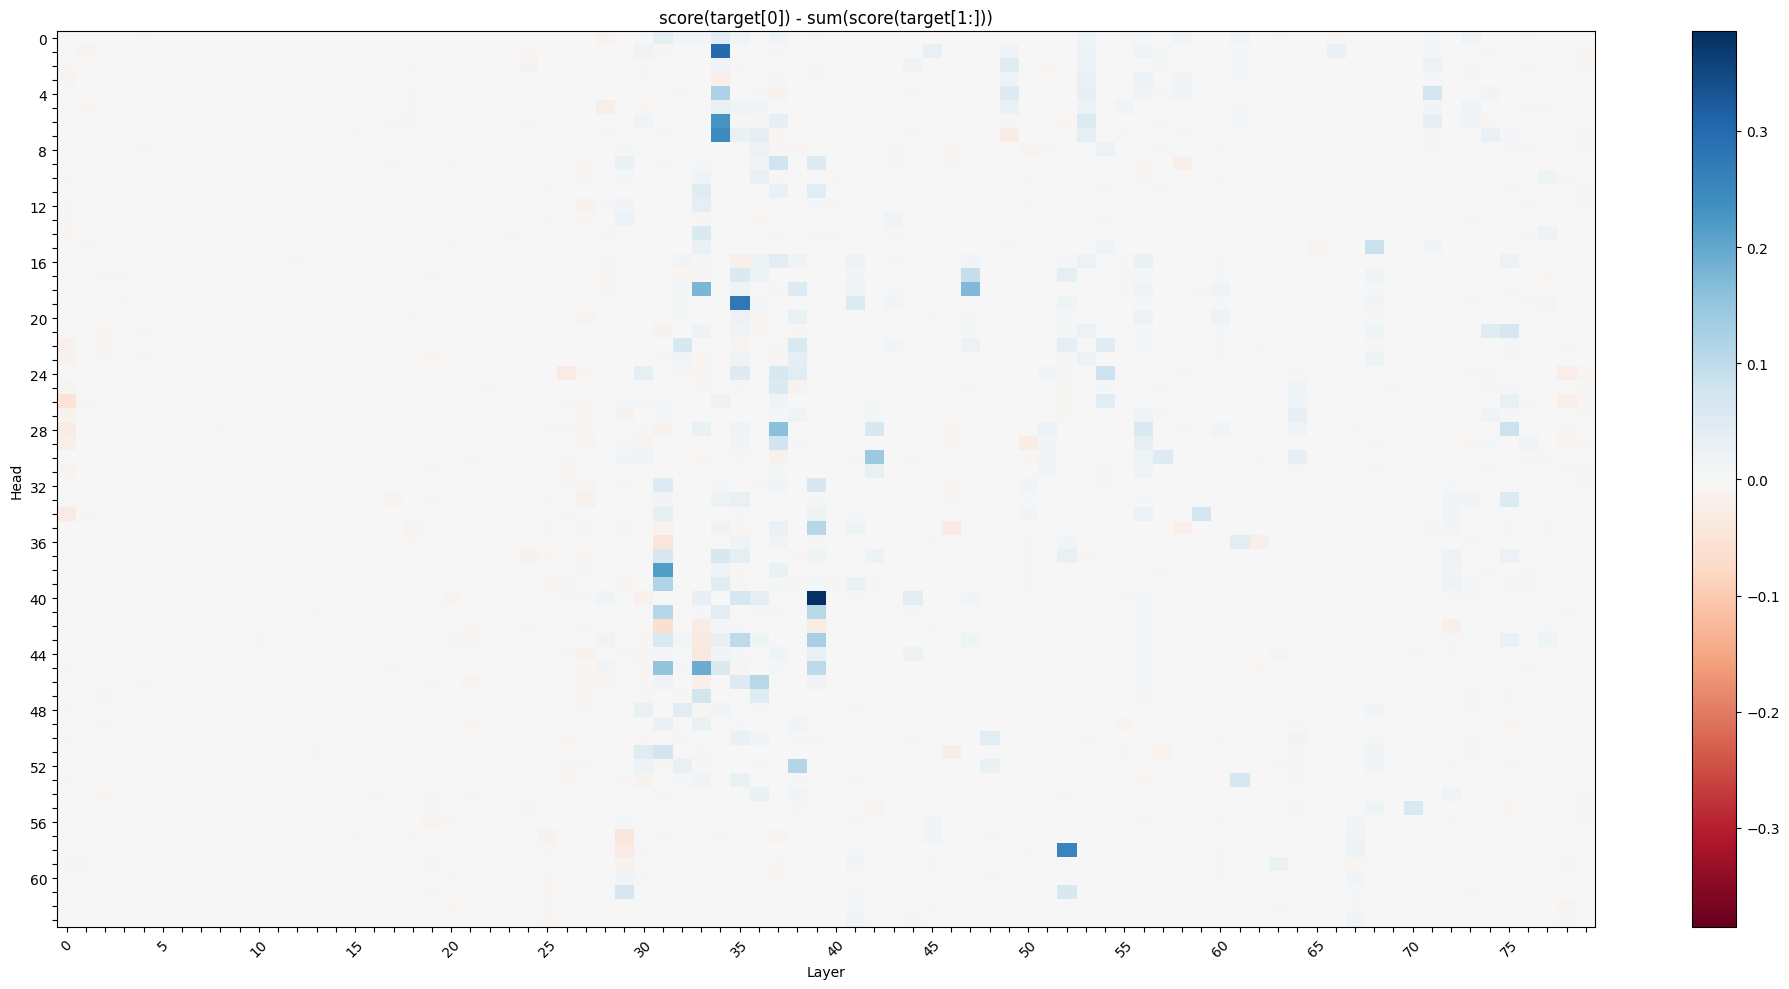

Layer 39, Head 40: 0.3857
Layer 34, Head 1: 0.3005
Layer 35, Head 19: 0.2758
Layer 52, Head 58: 0.2548
Layer 34, Head 7: 0.2447
Layer 34, Head 6: 0.2291
Layer 31, Head 38: 0.2148
Layer 33, Head 45: 0.1922
Layer 33, Head 18: 0.1749
Layer 47, Head 18: 0.1712
Layer 37, Head 28: 0.1607
Layer 31, Head 45: 0.1527
Layer 42, Head 30: 0.1432
Layer 39, Head 43: 0.1287
Layer 34, Head 4: 0.1216


In [169]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 10))
scale = torch.max(torch.abs(resolution_scores))
plt.imshow(
    resolution_scores.cpu().numpy(),
    cmap="RdBu",
    aspect="auto",
    vmin=-scale,
    vmax=scale,
)
plt.colorbar()
# plt.title(f"score(target) - max(score(distractors)) | {token_idx.upper()} tokens of options")
plt.title("score(target[0]) - sum(score(target[1:]))")
plt.xlabel("Layer")
plt.ylabel("Head")

def get_ticks(ticks, skip=5):
    ret = []
    for i in ticks:
        if i % skip == 0:
            ret.append(str(i))
        else:
            ret.append("")
    return ret

plt.xticks(
    ticks=range(n_layer),
    labels=get_ticks(range(n_layer)),
    rotation=45,
)
plt.yticks(
    ticks=range(n_head),
    labels=get_ticks(range(n_head), skip=4),
)

plt.tight_layout()
plt.show()


scores_per_head = []
for head_idx in range(n_head):
    for layer_idx in range(n_layer):
        scores_per_head.append(
            (head_idx, layer_idx, resolution_scores[head_idx, layer_idx].item())
        )

scores_per_head = sorted(scores_per_head, key=lambda x: x[2], reverse=True)
for head_idx, layer_idx, score in scores_per_head[:15]:
    print(f"Layer {layer_idx}, Head {head_idx}: {score:.4f}")

In [177]:
HEADS = [(layer_idx, head_idx) for head_idx, layer_idx, score in scores_per_head[:100]]
print(HEADS)

[(39, 40), (34, 1), (35, 19), (52, 58), (34, 7), (34, 6), (31, 38), (33, 45), (33, 18), (47, 18), (37, 28), (31, 45), (42, 30), (39, 43), (34, 4), (31, 39), (38, 52), (31, 41), (39, 35), (39, 41), (36, 46), (39, 45), (35, 43), (47, 17), (68, 15), (75, 28), (54, 24), (37, 29), (37, 9), (59, 34), (71, 4), (31, 51), (33, 47), (35, 40), (61, 53), (75, 21), (29, 61), (32, 22), (31, 37), (39, 32), (52, 61), (34, 37), (42, 28), (70, 55), (37, 24), (38, 22), (56, 28), (31, 43), (37, 25), (34, 45), (35, 17), (33, 14), (75, 33), (41, 19), (53, 6), (35, 46), (38, 18), (35, 24), (57, 30), (31, 32), (39, 9), (49, 4), (74, 21), (30, 51), (49, 2), (54, 22), (36, 47), (33, 11), (32, 48), (34, 0), (48, 50), (61, 36), (38, 24), (34, 41), (34, 39), (44, 40), (54, 26), (37, 16), (39, 11), (56, 29), (31, 0), (36, 40), (31, 34), (52, 17), (30, 24), (35, 37), (38, 23), (52, 22), (53, 7), (33, 12), (36, 7), (71, 6), (53, 4), (64, 27), (33, 40), (64, 30), (37, 6), (34, 43), (30, 48), (32, 52)]


#### Based on Patching Score

In [87]:
from scripts.patching_within_task import SelectionQprojPatchResult
from tqdm.auto import tqdm


q_proj_root = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/q_states_patching",
    mt.name.split("/")[-1],
)

#############################################
# LIMIT = 10
LIMIT = None
n_layer = mt.n_layer
n_head = mt.config.num_attention_heads
categories = [
    "profession",
    "nationality",
    "objects",
]
#############################################

q_proj_results = {cat: [] for cat in categories}

for category in categories:
    print(f"category: {category}")
    q_proj_path = os.path.join(q_proj_root, category)
    files = sorted(os.listdir(q_proj_path))
    LIMIT = LIMIT or len(files)
    q_proj_results[category] = []
    for file in tqdm(files[:LIMIT]):
        if not file.endswith(".json"):
            continue

        file_path = os.path.join(q_proj_path, file)
        q_proj_results[category].append(SelectionQprojPatchResult.load_from_json(file_path))
        # if len(q_proj_results) % 10 == 0:
        #     print(f"Loaded {len(q_proj_results)}/{LIMIT} files")



category: profession


  0%|          | 0/150 [00:00<?, ?it/s]

category: nationality


  0%|          | 0/150 [00:00<?, ?it/s]

category: objects


  0%|          | 0/150 [00:00<?, ?it/s]

In [88]:
combine_all_results = []
for category in categories:
    combine_all_results.extend(q_proj_results[category])

results_copy = copy.deepcopy(q_proj_results)
results_copy["all"] = combine_all_results

In [89]:
len(results_copy["profession"])

150

2025-08-11 09:32:36 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7ee8e35d08d0>
2025-08-11 09:32:36 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2025-08-11 09:32:36 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-08-11 09:32:36 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2025-08-11 09:32:36 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/

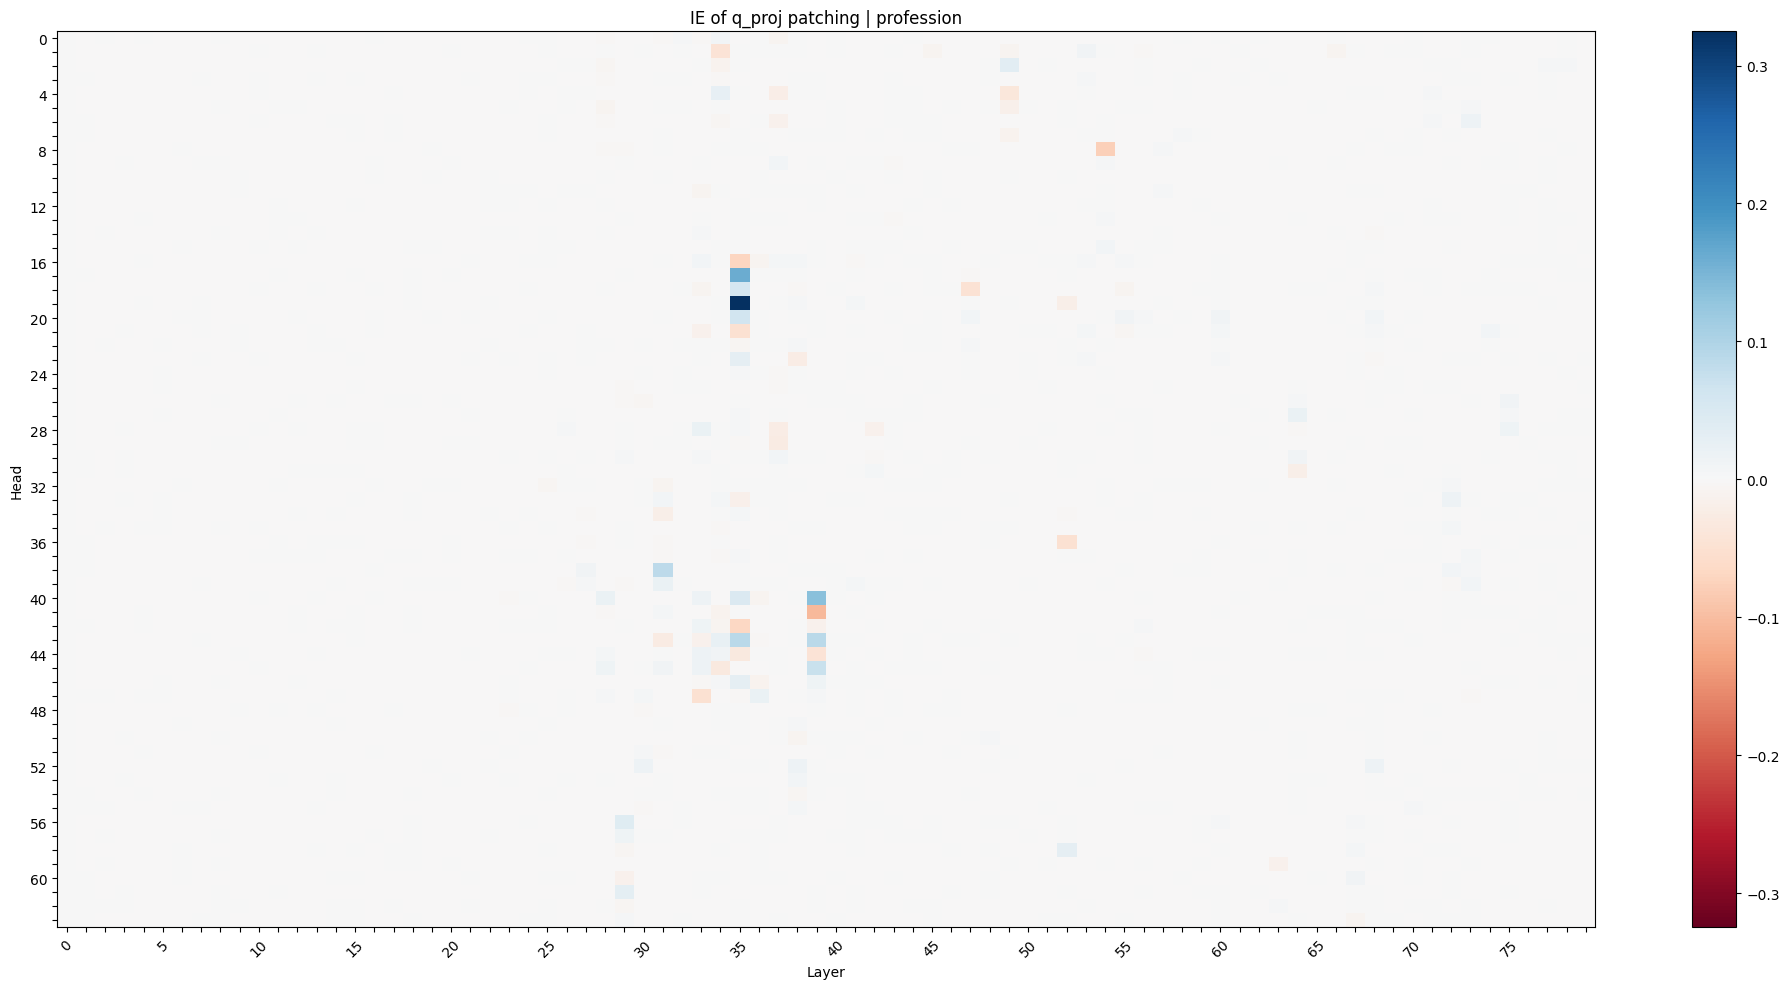

Layer 35, Head 19: 0.3248
Layer 35, Head 17: 0.1599
Layer 39, Head 40: 0.1348
Layer 39, Head 43: 0.0881
Layer 35, Head 43: 0.0880
Layer 31, Head 38: 0.0852
Layer 39, Head 45: 0.0720
Layer 35, Head 20: 0.0617
Layer 35, Head 18: 0.0551
Layer 35, Head 40: 0.0461
Layer 29, Head 56: 0.0398
Layer 49, Head 2: 0.0334
Layer 29, Head 61: 0.0324
Layer 52, Head 58: 0.0303
Layer 35, Head 23: 0.0298
2025-08-11 09:32:39 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7ee8e4868250>


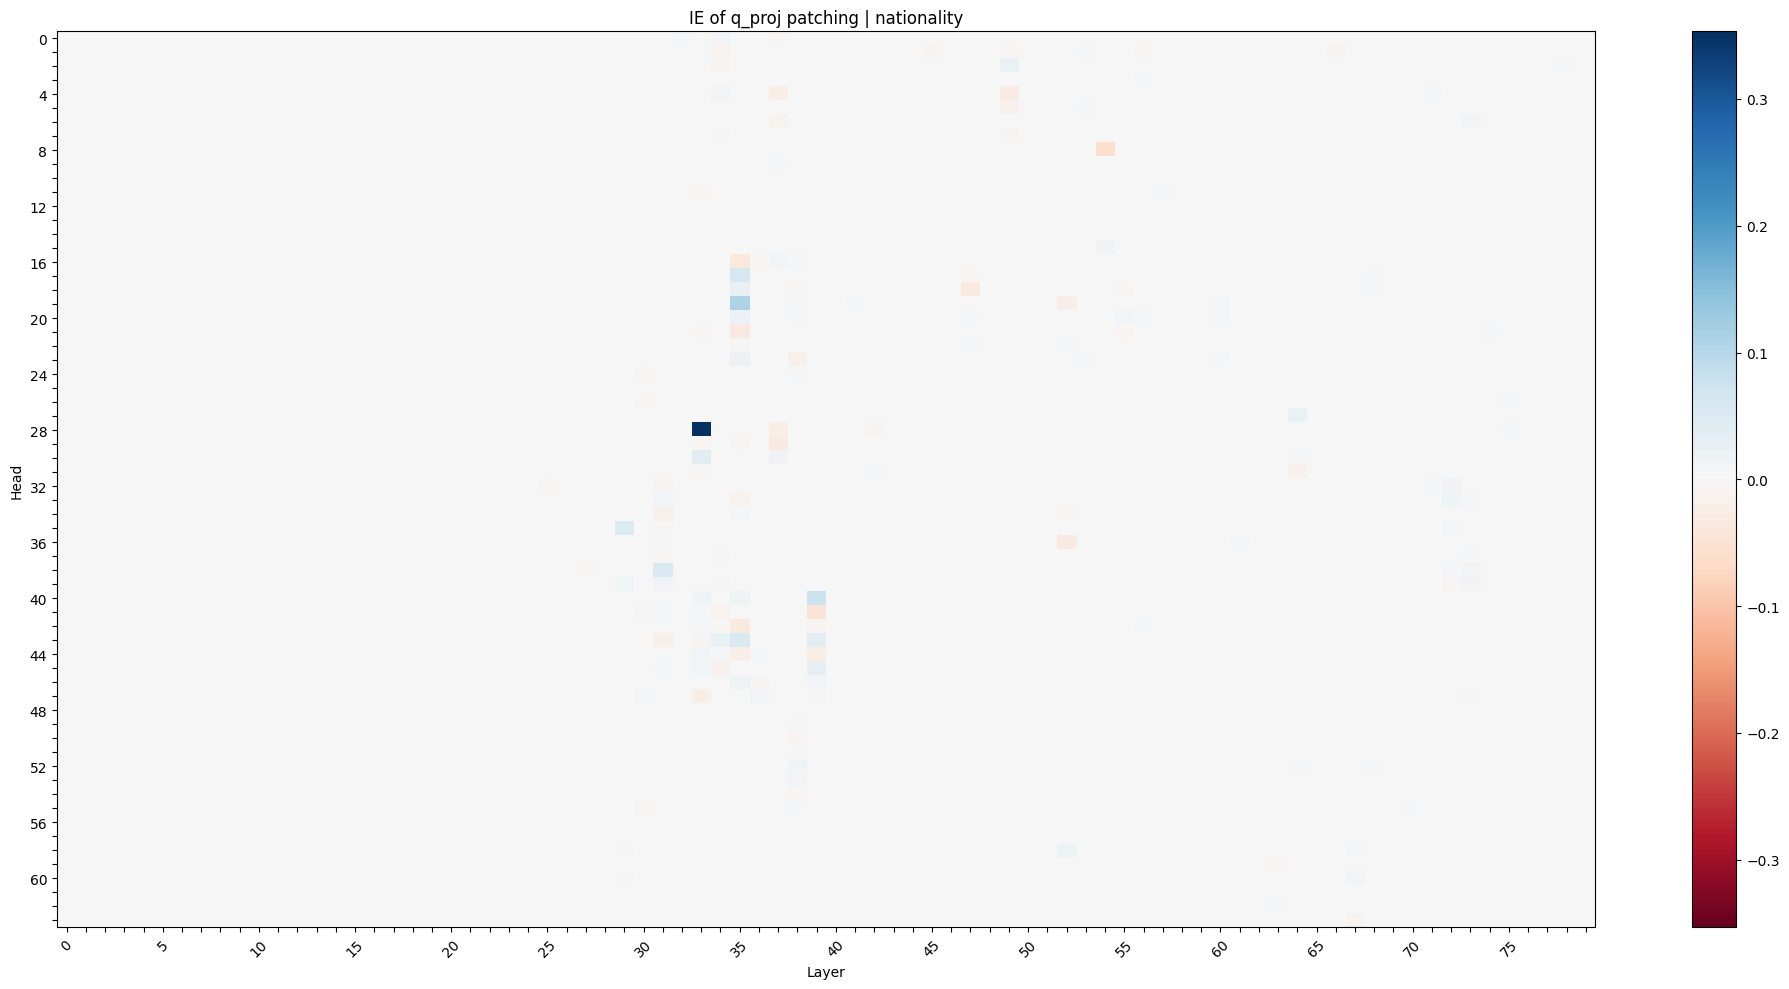

Layer 33, Head 28: 0.3533
Layer 35, Head 19: 0.1081
Layer 39, Head 40: 0.0748
Layer 35, Head 17: 0.0591
Layer 31, Head 38: 0.0549
Layer 35, Head 43: 0.0528
Layer 29, Head 35: 0.0495
Layer 39, Head 43: 0.0403
Layer 33, Head 30: 0.0362
Layer 39, Head 45: 0.0306
Layer 35, Head 18: 0.0274
Layer 34, Head 43: 0.0253
Layer 49, Head 2: 0.0233
Layer 64, Head 27: 0.0224
Layer 35, Head 20: 0.0211
2025-08-11 09:32:41 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7ee8f1d976d0>


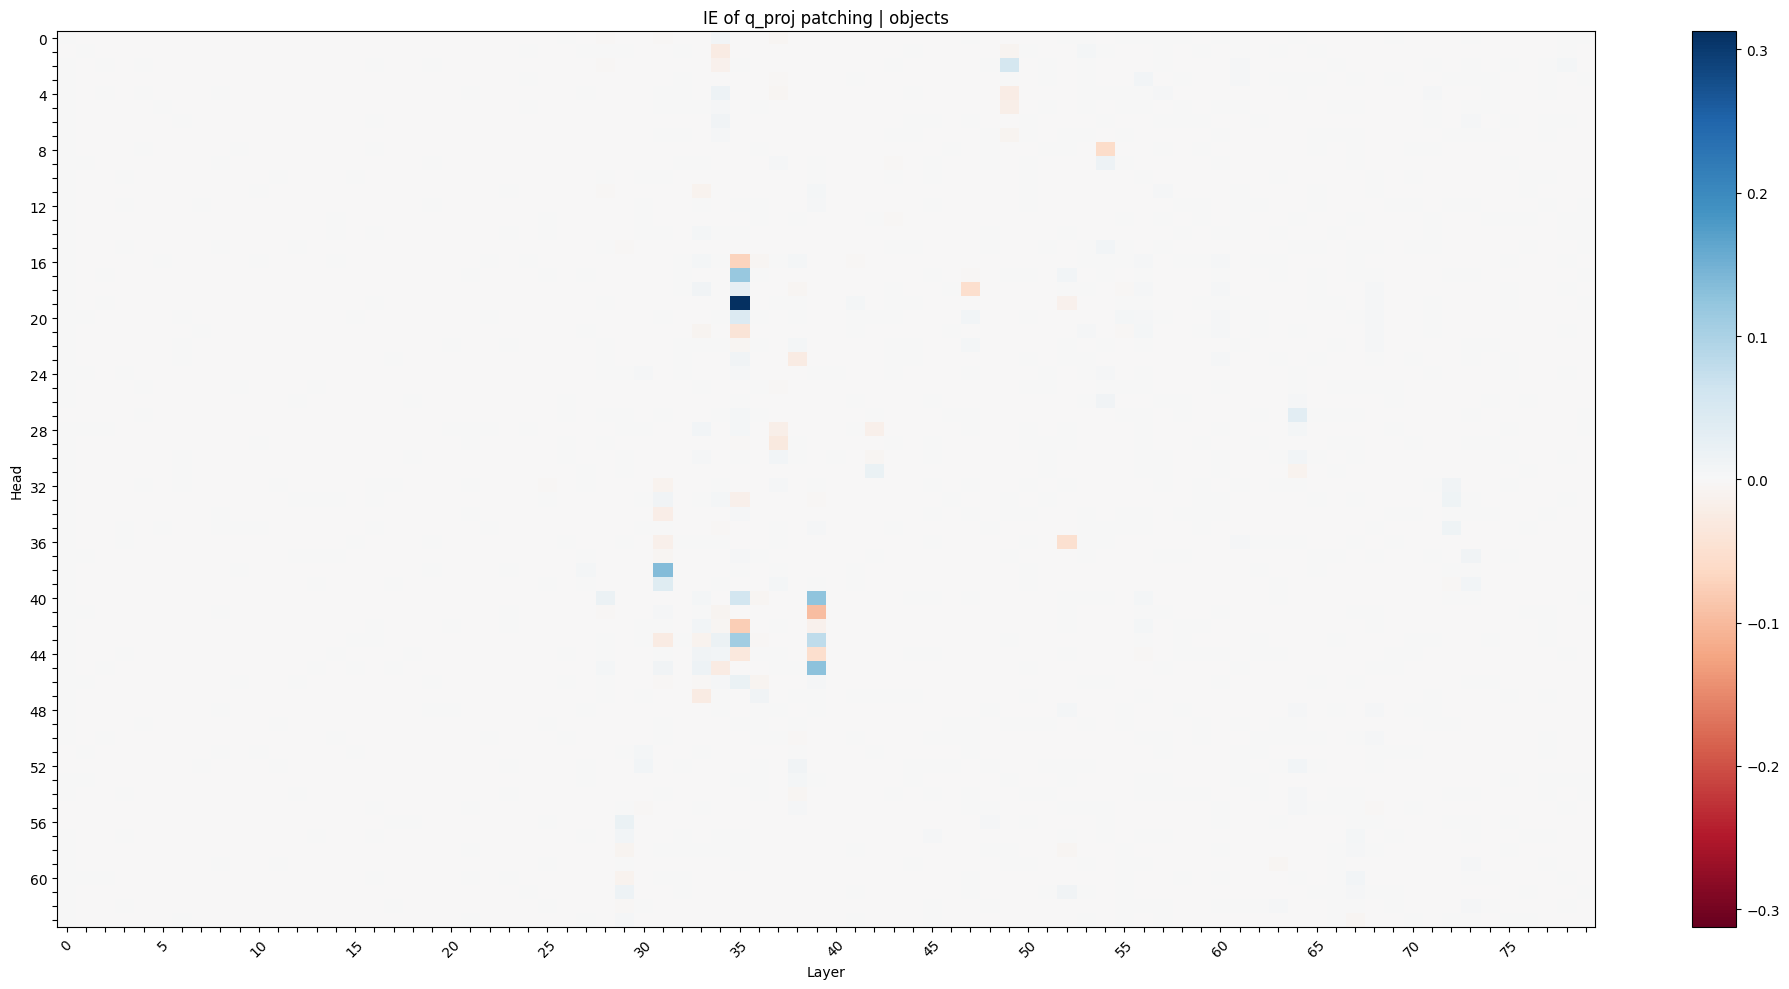

Layer 35, Head 19: 0.3127
Layer 31, Head 38: 0.1344
Layer 39, Head 45: 0.1280
Layer 39, Head 40: 0.1267
Layer 35, Head 17: 0.1187
Layer 35, Head 43: 0.1093
Layer 39, Head 43: 0.0782
Layer 35, Head 40: 0.0585
Layer 49, Head 2: 0.0557
Layer 35, Head 20: 0.0431
Layer 31, Head 39: 0.0375
Layer 64, Head 27: 0.0333
Layer 35, Head 18: 0.0262
Layer 29, Head 56: 0.0206
Layer 42, Head 31: 0.0205
2025-08-11 09:32:48 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7ee8f2f10150>


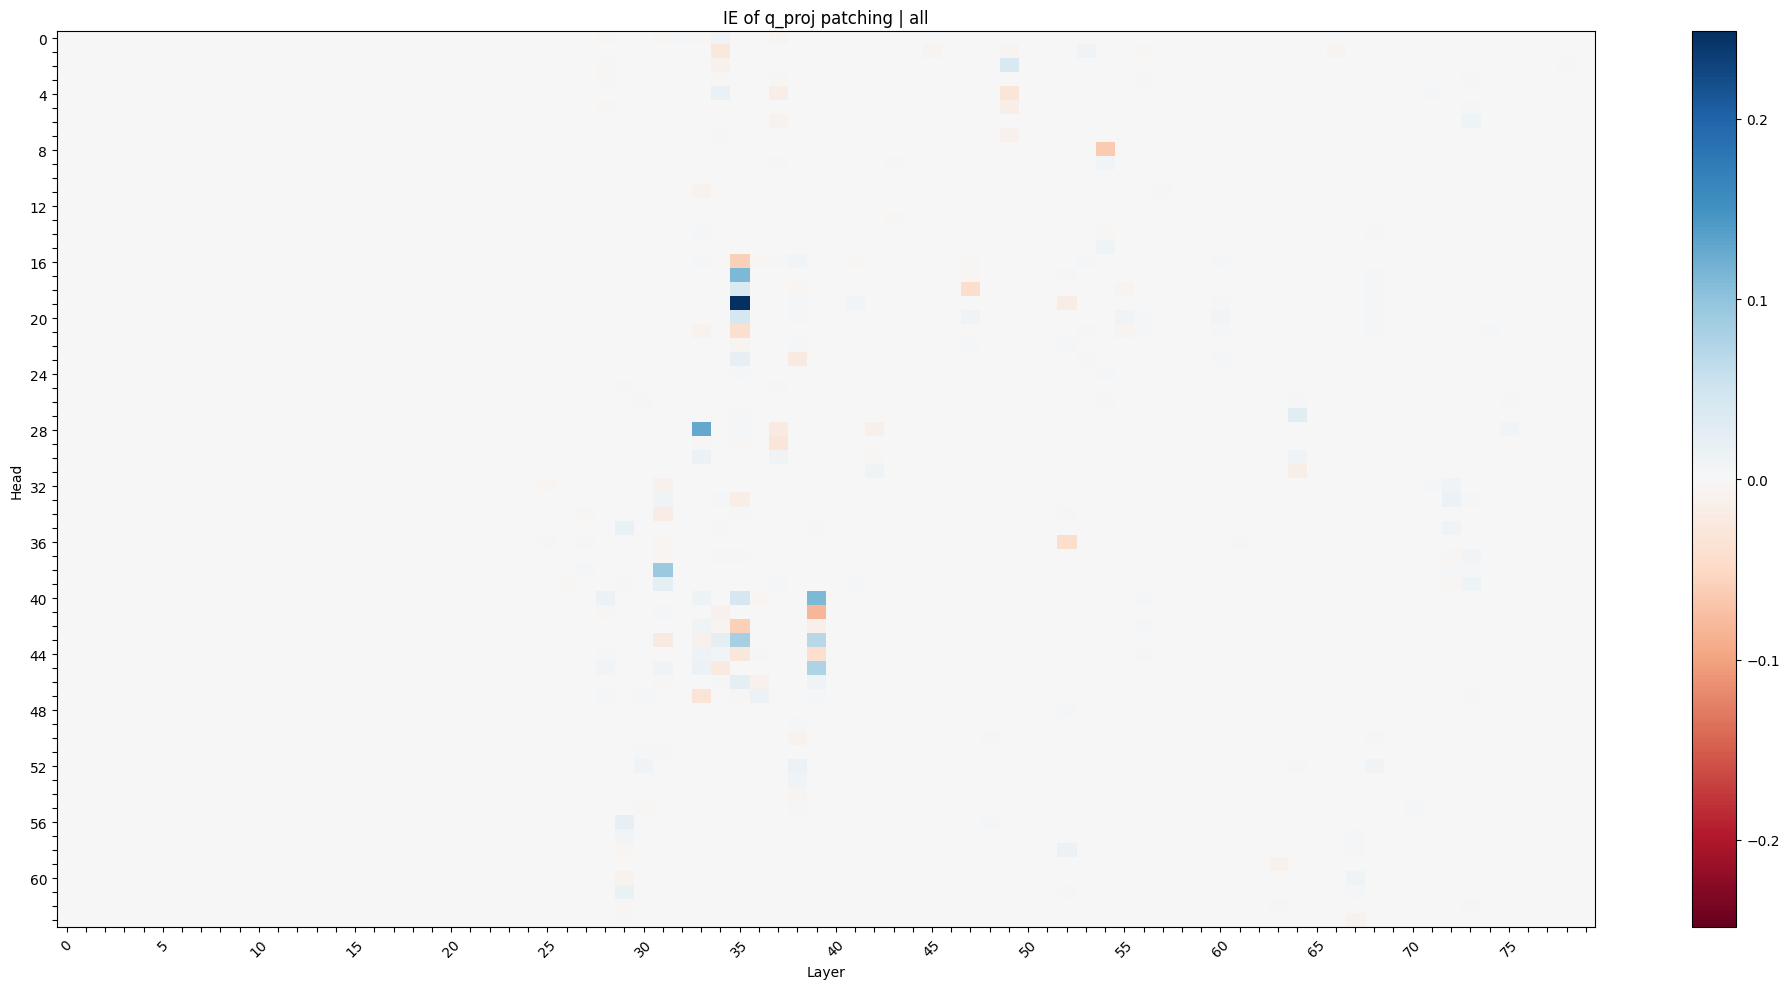

Layer 35, Head 19: 0.2485
Layer 33, Head 28: 0.1277
Layer 35, Head 17: 0.1126
Layer 39, Head 40: 0.1121
Layer 31, Head 38: 0.0915
Layer 35, Head 43: 0.0834
Layer 39, Head 45: 0.0769
Layer 39, Head 43: 0.0689
Layer 35, Head 20: 0.0420
Layer 35, Head 40: 0.0412
Layer 49, Head 2: 0.0375
Layer 35, Head 18: 0.0362
Layer 64, Head 27: 0.0256
Layer 31, Head 39: 0.0239
Layer 35, Head 46: 0.0223


In [90]:
from matplotlib import pyplot as plt

category_wise_heads = {}
for category, categorywise_result in results_copy.items():
    indirect_effects = torch.zeros((n_layer, n_heads), dtype=torch.float32)
    for layer_idx in range(mt.n_layer):
        for head_idx in range(mt.config.num_attention_heads):
            indirect_effects[layer_idx, head_idx] = torch.mean(
                torch.tensor(
                    [
                        sample_result.head_effect(layer_idx, head_idx)
                        for sample_result in categorywise_result
                    ]
                )
            )

    plt.figure(figsize=(20, 10))
    scale = torch.max(torch.abs(indirect_effects))
    plt.imshow(
        indirect_effects.T.cpu().numpy(),
        cmap="RdBu",
        aspect="auto",
        vmin=-scale,
        vmax=scale,
    )
    plt.colorbar()
    # plt.title(f"score(target) - max(score(distractors)) | {token_idx.upper()} tokens of options")
    plt.title("IE of q_proj patching | " + category)
    plt.xlabel("Layer")
    plt.ylabel("Head")

    def get_ticks(ticks, skip=5):
        ret = []
        for i in ticks:
            if i % skip == 0:
                ret.append(str(i))
            else:
                ret.append("")
        return ret

    plt.xticks(
        ticks=range(n_layer),
        labels=get_ticks(range(n_layer)),
        rotation=45,
    )
    plt.yticks(
        ticks=range(n_head),
        labels=get_ticks(range(n_head), skip=4),
    )

    plt.tight_layout()
    plt.show()


    scores_per_head = []
    for layer_idx in range(n_layer):
        for head_idx in range(n_head):
            scores_per_head.append(
                (layer_idx, head_idx, indirect_effects[layer_idx, head_idx].item())
            )

    scores_per_head = sorted(scores_per_head, key=lambda x: x[2], reverse=True)
    category_wise_heads[category] = scores_per_head
    for layer_idx, head_idx, score in scores_per_head[:15]:
        print(f"Layer {layer_idx}, Head {head_idx}: {score:.4f}")

with open("category_wise_heads.json", "w") as f:
    json.dump(category_wise_heads, f, indent=4)

#### Performing the Patch

In [32]:
from src.tokens import prepare_input
from src.functional import get_module_nnsight

# HEADS = [
#     (33, 45),
#     (33, 18),
#     (34, 1),
#     (34, 6),
#     (34, 7),
#     (35, 19),
#     (39, 40),
#     (42, 30),
#     (47, 18),
#     (52, 58),
# ]

# HEADS = [
#     (layer_idx, head_idx)
#     for layer_idx, head_idx, score in category_wise_heads["all"][:50]
# ]

# HEADS = heads_selected

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)
patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)

# category_wise_heads["all"][len(HEADS) - 1]

In [28]:
from src.utils.typing import TokenizerOutput


@torch.inference_mode()
def cache_q_projections(
    mt: ModelandTokenizer,
    input: TokenizerOutput,
    query_locations: list[tuple[int, int, int]],  # (layer_idx, head_idx, query_idx)
    return_output: bool = False,
):
    layer_to_hq = {}
    for layer_idx, head_idx, query_idx in query_locations:
        if layer_idx not in layer_to_hq:
            layer_to_hq[layer_idx] = []
        layer_to_hq[layer_idx].append((head_idx, query_idx))

    q_projections = {}
    batch_size = input.input_ids.shape[0]
    seq_len = input.input_ids.shape[1]
    n_heads = mt.config.num_attention_heads
    head_dim = mt.n_embd // n_heads
    with mt.trace(input) as tracer:
        for layer_idx, query_locs in layer_to_hq.items():
            q_proj_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
            q_proj_module = get_module_nnsight(mt, q_proj_name)
            q_proj_out = q_proj_module.output.view(
                batch_size, seq_len, n_heads, head_dim
            ).transpose(1, 2)
            for head_idx, query_idx in query_locs:
                q_projections[(layer_idx, head_idx, query_idx)] = (
                    q_proj_out[:, head_idx, query_idx, :].squeeze().save()
                )

        if return_output:
            output = mt.output.save()

    if return_output:
        return q_projections, output
    return q_projections

In [51]:
query_indices = list(range(-3, 0))
query_locations = [
    (layer_idx, head_idx, query_idx)
    for layer_idx, head_idx in HEADS
    for query_idx in query_indices
]

cached_q_states = cache_q_projections(
    mt=mt,
    input=patch_tokenized,
    query_locations=query_locations,
)

# cached_q_states[(HEADS[0])].shape

In [52]:
from src.attention import get_attention_matrices, visualize_attn_matrix
from src.functional import interpret_logits

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)

# attn_info = get_attention_matrices(
#     input=clean_tokenized,
#     mt=mt,
# )

# layer_idx, head_idx = 35, 19
# attn_matrix = attn_info.attention_matrices[layer_idx, head_idx].squeeze()
# visualize_attn_matrix(
#     attn_matrix=attn_matrix,
#     tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
#     q_index=-1,
# )

# interpret_logits(
#     tokenizer=mt,
#     logits=attn_info.logits,
#     interested_tokens=[clean_sample.obj_token_id, clean_sample.metadata["track_type_obj_token_id"]]
# )

attn_pattern = verify_head_patterns(
    prompt = clean_tokenized,
    options = clean_sample.options,
    pivot = clean_sample.subj,
    mt = mt,
    heads = HEADS,
    # heads = patching_heads,
    generate_full_answer=True,
)

attn_pattern["predictions"]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-13 18:15:22 src.experiments.utils DEBUG    Generated full answer: " Submarine.
Explanation: A submarine is a type of underwater vehicle that is used for various purposes, including military, scientific research, and exploration. It"
2025-08-13 18:15:22 src.experiments.utils DEBUG    Predictions: ['" Sub"[3804] (p=0.758, logit=21.375)', '" A"[362] (p=0.116, logit=19.500)', '" The"[578] (p=0.055, logit=18.750)', '" Among"[22395] (p=0.029, logit=18.125)', '" It"[1102] (p=0.008, logit=16.875)']
2025-08-13 18:15:22 src.experiments.utils INFO     Combined attention matrix for all heads


[PredictedToken(token=' Sub', prob=0.7578125, logit=21.375, token_id=3804, metadata=None),
 PredictedToken(token=' A', prob=0.11572265625, logit=19.5, token_id=362, metadata=None),
 PredictedToken(token=' The', prob=0.0546875, logit=18.75, token_id=578, metadata=None),
 PredictedToken(token=' Among', prob=0.029296875, logit=18.125, token_id=22395, metadata=None),
 PredictedToken(token=' It', prob=0.0084228515625, logit=16.875, token_id=1102, metadata=None)]

In [53]:
from src.attention import get_attention_matrices, visualize_attn_matrix
from src.functional import patch_with_nnsight, patch_with_baukit, PatchSpec

q_proj_patches = []
for (layer_idx, head_idx, query_idx), q_proj in cached_q_states.items():
    q_proj_patches.append(
        PatchSpec(
            location=(mt.attn_module_name_format.format(layer_idx) + ".q_proj", head_idx, query_idx),
            patch=q_proj
        )
    )

# patched_attn_info = get_attention_matrices(
#     input=clean_tokenized,
#     mt=mt,
#     patches=q_proj_patches,
#     patch_interface=patch_with_baukit
# )

# layer_idx, head_idx = 35, 19
# patched_attn_matrix = patched_attn_info.attention_matrices[layer_idx, head_idx].squeeze()
# visualize_attn_matrix(
#     attn_matrix=patched_attn_matrix,
#     tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
#     q_index=-1,
# )

# interpret_logits(
#     tokenizer=mt,
#     logits=patched_attn_info.logits,
#     interested_tokens=[clean_sample.obj_token_id, clean_sample.metadata["track_type_obj_token_id"]]
# )

patched_attn_pattern = verify_head_patterns(
    prompt = clean_tokenized,
    options = clean_sample.options,
    pivot = clean_sample.subj,
    mt = mt,
    heads = HEADS,
    # heads = patching_heads,
    query_patches=q_proj_patches,
    # generate_full_answer=True,
)

patched_attn_pattern["predictions"]

249 patches to ablate possible answer information from options
2025-08-13 18:15:29 src.experiments.utils DEBUG    Predictions: ['" Apple"[8325] (p=0.809, logit=21.625)', '" The"[578] (p=0.046, logit=18.750)', '" An"[1556] (p=0.040, logit=18.625)', '" Palm"[33578] (p=0.036, logit=18.500)', '" Among"[22395] (p=0.024, logit=18.125)']
2025-08-13 18:15:29 src.experiments.utils INFO     Combined attention matrix for all heads


[PredictedToken(token=' Apple', prob=0.80859375, logit=21.625, token_id=8325, metadata=None),
 PredictedToken(token=' The', prob=0.045654296875, logit=18.75, token_id=578, metadata=None),
 PredictedToken(token=' An', prob=0.040283203125, logit=18.625, token_id=1556, metadata=None),
 PredictedToken(token=' Palm', prob=0.03564453125, logit=18.5, token_id=33578, metadata=None),
 PredictedToken(token=' Among', prob=0.0244140625, logit=18.125, token_id=22395, metadata=None)]

### Search over layers and heads

In [48]:
clean_sample.metadata

{'track_category': 'building',
 'track_type_obj': 'Hospital',
 'track_type_obj_idx': 2,
 'track_type_obj_token_id': 15429}

In [49]:
from scripts.patching_within_task import SelectionQprojPatchResult

In [ ]:
from itertools import product
from src.functional import patch_with_baukit, interpret_logits

interested_tokens = [
    patch_sample.ans_token_id,
    clean_sample.ans_token_id,
    clean_sample.metadata["track_type_obj_token_id"]
]
all_heads = list(product(range(20, 60), range(mt.config.num_attention_heads)))
all_q_projections, patch_out = cache_q_projections(
    mt=mt,
    input=patch_tokenized,
    heads=all_heads,
    query_idx=-1,
    return_output=True
)
logger.debug(len(all_q_projections))

patch_logits = patch_out.logits[:, -1, :].squeeze()
patch_precitions, patch_track = interpret_logits(
    tokenizer=mt,
    logits=patch_logits,
    interested_tokens=interested_tokens,
)

patch_precitions, patch_track

2025-08-11 10:40:18 __main__ DEBUG    2560


([PredictedToken(token=' House', prob=0.85546875, logit=22.5, token_id=4783, metadata=None),
  PredictedToken(token=' The', prob=0.042724609375, logit=19.5, token_id=578, metadata=None),
  PredictedToken(token=' A', prob=0.042724609375, logit=19.5, token_id=362, metadata=None),
  PredictedToken(token=' Among', prob=0.02587890625, logit=19.0, token_id=22395, metadata=None),
  PredictedToken(token=' It', prob=0.005096435546875, logit=17.375, token_id=1102, metadata=None)],
 {4783: (1,
   PredictedToken(token=' House', prob=0.85546875, logit=22.5, token_id=4783, metadata=None)),
  15429: (517,
   PredictedToken(token=' Hospital', prob=6.295740604400635e-07, logit=8.375, token_id=15429, metadata=None)),
  29318: (1873,
   PredictedToken(token=' Dress', prob=9.639188647270203e-08, logit=6.5, token_id=29318, metadata=None))})

In [51]:
clean_out = patch_with_baukit(
    mt=mt,
    inputs=clean_tokenized,
    patches=[],
)

base_logits = clean_out.logits[:, -1, :].squeeze()
base_predictions, base_track = interpret_logits(
    tokenizer=mt,
    logits=base_logits,
    interested_tokens=interested_tokens,
)
base_predictions, base_track

([PredictedToken(token=' Dress', prob=0.83203125, logit=22.375, token_id=29318, metadata=None),
  PredictedToken(token=' The', prob=0.060302734375, logit=19.75, token_id=578, metadata=None),
  PredictedToken(token=' A', prob=0.041259765625, logit=19.375, token_id=362, metadata=None),
  PredictedToken(token=' Among', prob=0.03662109375, logit=19.25, token_id=22395, metadata=None),
  PredictedToken(token=' D', prob=0.00634765625, logit=17.5, token_id=423, metadata=None)],
 {29318: (1,
   PredictedToken(token=' Dress', prob=0.83203125, logit=22.375, token_id=29318, metadata=None)),
  15429: (38,
   PredictedToken(token=' Hospital', prob=0.0001163482666015625, logit=13.5, token_id=15429, metadata=None)),
  4783: (452,
   PredictedToken(token=' House', prob=7.338821887969971e-07, logit=8.4375, token_id=4783, metadata=None))})

In [52]:
int_out = patch_with_baukit(
    mt = mt,
    inputs = clean_tokenized,
    patches = q_proj_patches,
)

logits = int_out.logits[:, -1, :].squeeze()

interpret_logits(
    tokenizer=mt,
    logits=logits,
    interested_tokens=interested_tokens
)

([PredictedToken(token=' Hospital', prob=0.796875, logit=21.625, token_id=15429, metadata=None),
  PredictedToken(token=' Among', prob=0.057861328125, logit=19.0, token_id=22395, metadata=None),
  PredictedToken(token=' The', prob=0.044921875, logit=18.75, token_id=578, metadata=None),
  PredictedToken(token=' A', prob=0.02734375, logit=18.25, token_id=362, metadata=None),
  PredictedToken(token=' Dress', prob=0.018798828125, logit=17.875, token_id=29318, metadata=None)],
 {15429: (1,
   PredictedToken(token=' Hospital', prob=0.796875, logit=21.625, token_id=15429, metadata=None)),
  29318: (5,
   PredictedToken(token=' Dress', prob=0.018798828125, logit=17.875, token_id=29318, metadata=None)),
  4783: (343,
   PredictedToken(token=' House', prob=2.4586915969848633e-06, logit=8.9375, token_id=4783, metadata=None))})

In [ ]:
head_wise_patching_effects = {}

for (layer_idx, head_idx), q_proj in tqdm(all_q_projections.items()):
    q_proj_patch = PatchSpec(
        location=(mt.attn_module_name_format.format(layer_idx) + ".q_proj", head_idx, -1),
        patch=q_proj
    )
    out = patch_with_baukit(
        mt = mt,
        inputs = clean_tokenized,
        patches = [q_proj_patch],
    )
    logits = out.logits[:, -1, :].squeeze()
    predictions, track = interpret_logits(
        tokenizer=mt,
        logits=logits,
        interested_tokens=interested_tokens
    )
    head_wise_patching_effects[(layer_idx, head_idx)] = track

  0%|          | 0/2560 [00:00<?, ?it/s]

Patched Layer 21, Head 35: [PredictedToken(token=' Will', prob=0.5625, logit=20.25, token_id=4946, metadata=None), PredictedToken(token=' (', prob=0.09765625, logit=18.5, token_id=320, metadata=None), PredictedToken(token=' Option', prob=0.076171875, logit=18.25, token_id=7104, metadata=None), PredictedToken(token=' ', prob=0.076171875, logit=18.25, token_id=220, metadata=None), PredictedToken(token=' The', prob=0.046142578125, logit=17.75, token_id=578, metadata=None)] | {4946: (1, PredictedToken(token=' Will', prob=0.5625, logit=20.25, token_id=4946, metadata=None)), 35336: (33, PredictedToken(token=' Nancy', prob=0.000659942626953125, logit=13.5, token_id=35336, metadata=None)), 11519: (639, PredictedToken(token=' Mike', prob=2.5331974029541016e-06, logit=7.9375, token_id=11519, metadata=None))}
Patched Layer 23, Head 7: [PredictedToken(token=' Will', prob=0.55859375, logit=20.25, token_id=4946, metadata=None), PredictedToken(token=' (', prob=0.09716796875, logit=18.5, token_id=320,

In [ ]:
patching_results = SelectionQprojPatchResult(
    patch_sample=patch_sample,
    clean_sample=clean_sample,
    interested_tokens=interested_tokens,
    base_results=base_track,
    gold_results=patch_track,
    headwise_patching_effects=head_wise_patching_effects
)

NameError: name 'head_wise_patching_effects' is not defined

In [ ]:
patching_results.head_effect(layer_idx=35, head_idx=19)

0.4214876033057851

In [ ]:
headwise_scores = [
    (
        layer_idx,
        head_idx,
        patching_results.head_effect(layer_idx, head_idx)
    )
    for layer_idx, head_idx in head_wise_patching_effects.keys()
]

headwise_scores = sorted(headwise_scores, key=lambda x: x[2], reverse=True)
patching_heads = []
for layer_idx, head_idx, score in headwise_scores[:15]:
    print(f"Layer {layer_idx}, Head {head_idx}: {score:.4f}")
    patching_heads.append((layer_idx, head_idx))

Layer 35, Head 19: 0.4215
Layer 39, Head 45: 0.2645
Layer 39, Head 43: 0.2397
Layer 31, Head 38: 0.1983
Layer 35, Head 20: 0.1818
Layer 35, Head 23: 0.0992
Layer 35, Head 43: 0.0992
Layer 35, Head 17: 0.0826
Layer 49, Head 2: 0.0744
Layer 31, Head 33: 0.0661
Layer 37, Head 30: 0.0661
Layer 35, Head 18: 0.0579
Layer 30, Head 52: 0.0496
Layer 31, Head 39: 0.0496
Layer 33, Head 47: 0.0496


In [ ]:
patching_results.delist_patching_effects()
with open("patching_results.json", "w") as f:
    json.dump(patching_results.to_dict(), f, indent=4)

In [ ]:
with open("patching_results.json", "r") as f:
    loaded_results = json.load(f)

loaded_results["headwise_patching_effects"] = {
    (int(layer_idx.split("_<>_")[0]), int(layer_idx.split("_<>_")[1])): effect
    for layer_idx, effect in loaded_results["headwise_patching_effects"].items()
}

In [ ]:
loaded_results["headwise_patching_effects"].keys()

In [ ]:
patching_results_loaded = SelectionQprojPatchResult.from_dict(loaded_results)
patching_results_loaded.head_effect(layer_idx=35, head_idx=19)

0.4214876033057851

In [ ]:
mt.config.num_attention_heads

64

## Optimization to select heads to patch

In [71]:
from torch.optim import AdamW
from torch.utils.data import DataLoader
from src.utils.typing import TokenizerOutput
from src.functional import free_gpu_cache
import baukit


def get_optimal_head_mask(
    mt: ModelandTokenizer,
    train_set: list[tuple[SelectionSample, SelectionSample]],
    learning_rate: float = 1e-3,
    n_epochs: int = 5,
    lamb: float = 1e-3,
    batch_size: int = 4,
    query_indices: int = [-1],
):
    hparams = {
        "learning_rate": learning_rate,
        "n_epochs": n_epochs,
        "lamb": lamb,
        "batch_size": batch_size,
    }
    logger.debug(f"Training with hparams: {hparams}")
    n_layer = mt.n_layer
    n_heads = mt.config.num_attention_heads

    mask = torch.ones(
        (n_layer, n_heads), dtype=mt.dtype, requires_grad=True, device=mt.device
    )

    # prompts = []
    # prompts.extend([sample.prompt() for sample in clean_samples])
    # prompts.extend([sample.prompt() for sample in patch_samples])
    # tokenized = prepare_input(prompts=prompts, tokenizer=mt)

    # clean_tokenized = TokenizerOutput(data = {k: v[:len(clean_samples), :] for k, v in tokenized.items()})
    # patch_tokenized = TokenizerOutput(data = {k: v[len(clean_samples):, :] for k, v in tokenized.items()})

    optimizer = AdamW([mask], lr=learning_rate)
    losses = []

    all_heads = [
        (layer_idx, head_idx)
        for layer_idx in range(n_layer)
        for head_idx in range(n_heads)
    ]
    all_q_proj_modules = [
        mt.attn_module_name_format.format(layer_idx) + ".q_proj"
        for layer_idx in range(n_layer)
    ]
    batches = []
    for batch_start in range(0, len(train_set), batch_size):
        batches.append(train_set[batch_start : batch_start + batch_size])

    query_locations = [
        (layer_idx, head_idx, query_idx)
        for layer_idx, head_idx in all_heads
        for query_idx in query_indices
    ]

    logger.info("Caching q projections from patch samples...")
    q_projections_from_patch_samples = {}
    for batch_idx, batch in enumerate(batches):
        clean_samples, patch_samples = zip(*batch)
        prompts = []
        prompts.extend([sample.prompt() for sample in clean_samples])
        prompts.extend([sample.prompt() for sample in patch_samples])
        tokenized = prepare_input(prompts=prompts, tokenizer=mt)
        # clean_tokenized = TokenizerOutput(data = {k: v[:len(clean_samples), :] for k, v in tokenized.items()})
        patch_tokenized = TokenizerOutput(
            data={k: v[len(clean_samples) :, :] for k, v in tokenized.items()}
        )

        q_projections = cache_q_projections(
            mt=mt,
            input=patch_tokenized,
            query_locations=query_locations,
            return_output=False,
        )

        patches = {}
        for (layer_idx, head_idx, query_idx), q_proj in q_projections.items():
            module_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
            patches[(module_name, head_idx)] = (layer_idx, q_proj)
        q_projections_from_patch_samples[batch_idx] = patches
        logger.info(f"Caching completed > {batch_idx+1}/{len(batches)} batches.")
        free_gpu_cache()

    logger.info("Starting training...")

    for epoch in range(n_epochs):
        epoch_loss = 0
        for batch_idx, batch in enumerate(batches):
            optimizer.zero_grad()

            batch_size_actual = len(batch)

            clean_samples, patch_samples = zip(*batch)
            prompts = []
            prompts.extend([sample.prompt() for sample in clean_samples])
            prompts.extend([sample.prompt() for sample in patch_samples])
            tokenized = prepare_input(prompts=prompts, tokenizer=mt)
            clean_tokenized = TokenizerOutput(
                data={k: v[: len(clean_samples), :] for k, v in tokenized.items()}
            )
            patch_tokenized = TokenizerOutput(
                data={k: v[len(clean_samples) :, :] for k, v in tokenized.items()}
            )
            batch_target_tokens = [
                clean_sample.metadata["track_type_obj_token_id"]
                for clean_sample in clean_samples
            ]
            batch_distractor_tokens = [
                [
                    get_first_token_id(tokenizer=mt.tokenizer, name=option, prefix=" ")
                    for idx, option in enumerate(clean_sample.options)
                    if idx != clean_sample.metadata["track_type_obj_idx"]
                ]
                for clean_sample in clean_samples
            ]

            patch_q_states = q_projections_from_patch_samples[batch_idx]

            batch_size = clean_tokenized.input_ids.shape[0]
            seq_len = clean_tokenized.input_ids.shape[1]
            head_dim = mt.n_embd // n_heads

            def perform_patch(repr, layer_name):
                if layer_name not in all_q_proj_modules:
                    return repr

                repr = repr.view(batch_size, seq_len, n_heads, head_dim).transpose(1, 2)
                for head_idx in range(n_heads):
                    q_clean = repr[:, head_idx, query_idx, :]
                    layer_idx, q_patch = patch_q_states[(layer_name, head_idx)]
                    q_patch = q_patch.clone().to(q_clean.dtype).to(q_clean.device)
                    q_patch.requires_grad = True
                    coeff = (
                        mask[layer_idx, head_idx].to(q_clean.dtype).to(q_clean.device)
                    )
                    # head_patch = coeff * q_patch + (1 - coeff) * q_clean
                    repr[:, head_idx, query_idx, :] += coeff * (q_patch - q_clean)

                repr = repr.transpose(1, 2).view(
                    batch_size, seq_len, n_heads * head_dim
                )
                return repr

            with baukit.TraceDict(
                module=mt._model, layers=all_q_proj_modules, edit_output=perform_patch
            ):
                output = mt._model(**clean_tokenized)

            logits = output.logits[:, -1, :]

            # calculate target loss
            target_logits = [
                logit[tok] for logit, tok in zip(logits, batch_target_tokens)
            ]
            target_loss = -torch.stack(target_logits).mean()  # need this to go up

            # calculate distractor loss
            distractor_logits = [
                logit[distractor_tokens].mean()
                for logit, distractor_tokens in zip(logits, batch_distractor_tokens)
            ]
            distractor_loss = torch.stack(distractor_logits).mean()

            # mask_loss
            mask_l1_loss = torch.abs(mask).sum() * lamb
            loss = target_loss + distractor_loss + mask_l1_loss
            logger.debug(
                f"Epoch={epoch+1} | {batch_idx=} |>> {target_loss.item():.4f} + {distractor_loss.item():.4f} + {mask_l1_loss.item():.4f} = {loss.item():.4f}"
            )

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                mask.clamp_(0, 1)
                mask += 1e-4  # to avoid zero gradients

            epoch_loss += loss.item() * batch_size_actual
            losses.append(loss.item())

        epoch_loss /= len(train_set)
        logger.info(f"Epoch {epoch+1}/{n_epochs} completed. Avg Loss: {epoch_loss:.4f}")

    mt._model.zero_grad()
    with torch.no_grad():
        mask.clamp_(0, 1)

    free_gpu_cache()
    return mask.detach().cpu(), losses

In [72]:
# print(clean_sample.prompt(), ">>", clean_sample.obj)
# print(patch_sample.prompt(), ">>", patch_sample.obj)

# train_set = [(clean_sample, patch_sample)]


In [ ]:
free_gpu_cache()

#################################################################################
train_limit = 512
TASK_CLS = SelectOrderTask
prompt_template_idx = 1
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

train_set = []
while len(train_set) < train_limit:
    patch, clean = get_counterfactual_samples_within_task(
        filter_by_lm_prediction=True,
        prompt_template_idx=prompt_template_idx,
        option_style=OPTION_STYLE,
        distinct_options=True,
        n_distractors=N_DISTRACTORS,
    )
    train_set.append((clean, patch))

2025-08-13 22:58:01 __main__ INFO     Patch category: furniture, subject: Coffee table, object: Recliner
2025-08-13 22:58:01 __main__ INFO     Clean category: jewelry, subject: Charm, object: Locket
2025-08-13 22:58:01 __main__ INFO     patch_must_have_options=['Recliner', 'Bangle']
2025-08-13 22:58:01 __main__ INFO     clean_must_have_options=['Locket', 'Nightstand']
2025-08-13 22:58:01 __main__ INFO     clean_type_obj='Bangle'
2025-08-13 22:58:01 __main__ INFO     patch_type_obj='Nightstand'
2025-08-13 22:58:01 __main__ INFO     patch_obj_idx=4 | ['Daffodil', 'Shirt', 'Bangle', 'Airplane', 'Recliner', 'Onion']
2025-08-13 22:58:01 __main__ INFO     clean_obj_idx=3 | ['Bear', 'Grape', 'Boat', 'Locket', 'Nightstand', 'Juicer']
type(task)=<class 'src.selection.data.SelectOrderTask'>
2025-08-13 22:58:01 __main__ INFO     Options: Daffodil, Shirt, Bangle, Airplane, Recliner, Onion.
What is the fifth object from the list above?
Answer:
2025-08-13 22:58:01 __main__ INFO     Coffee table | fu

In [78]:
mt._model.zero_grad()
free_gpu_cache()

In [79]:
free_gpu_cache()
optimal_mask, losses = get_optimal_head_mask(
    mt=mt,
    train_set=train_set,
    learning_rate=1e-2,
    n_epochs=20,
    lamb=2e-2,
    batch_size=16,
    query_indices=[-3, -2, -1],
)

2025-08-13 23:04:35 __main__ DEBUG    Training with hparams: {'learning_rate': 0.01, 'n_epochs': 20, 'lamb': 0.02, 'batch_size': 16}
2025-08-13 23:04:35 __main__ INFO     Caching q projections from patch samples...
2025-08-13 23:04:44 __main__ INFO     Caching completed > 1/32 batches.
2025-08-13 23:04:54 __main__ INFO     Caching completed > 2/32 batches.
2025-08-13 23:05:04 __main__ INFO     Caching completed > 3/32 batches.
2025-08-13 23:05:14 __main__ INFO     Caching completed > 4/32 batches.
2025-08-13 23:05:24 __main__ INFO     Caching completed > 5/32 batches.
2025-08-13 23:05:34 __main__ INFO     Caching completed > 6/32 batches.
2025-08-13 23:05:44 __main__ INFO     Caching completed > 7/32 batches.
2025-08-13 23:05:54 __main__ INFO     Caching completed > 8/32 batches.
2025-08-13 23:06:04 __main__ INFO     Caching completed > 9/32 batches.
2025-08-13 23:06:13 __main__ INFO     Caching completed > 10/32 batches.
2025-08-13 23:06:23 __main__ INFO     Caching completed > 11/32 

In [82]:
import numpy as np

np.savez_compressed("optimized_heads_order.npz", **dict(
    optimal_mask=optimal_mask.to(torch.float32).numpy(),
    losses=np.array(losses, dtype=np.float32)
), allow_pickle=True)

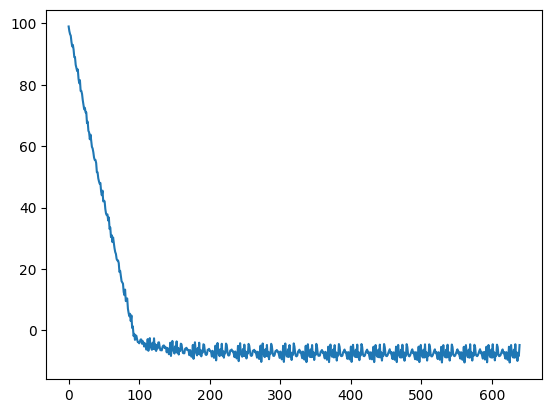

In [83]:
from matplotlib import pyplot as plt

optimization_results = np.load("optimized_heads_order.npz", allow_pickle=True)
plt.plot(optimization_results["losses"])

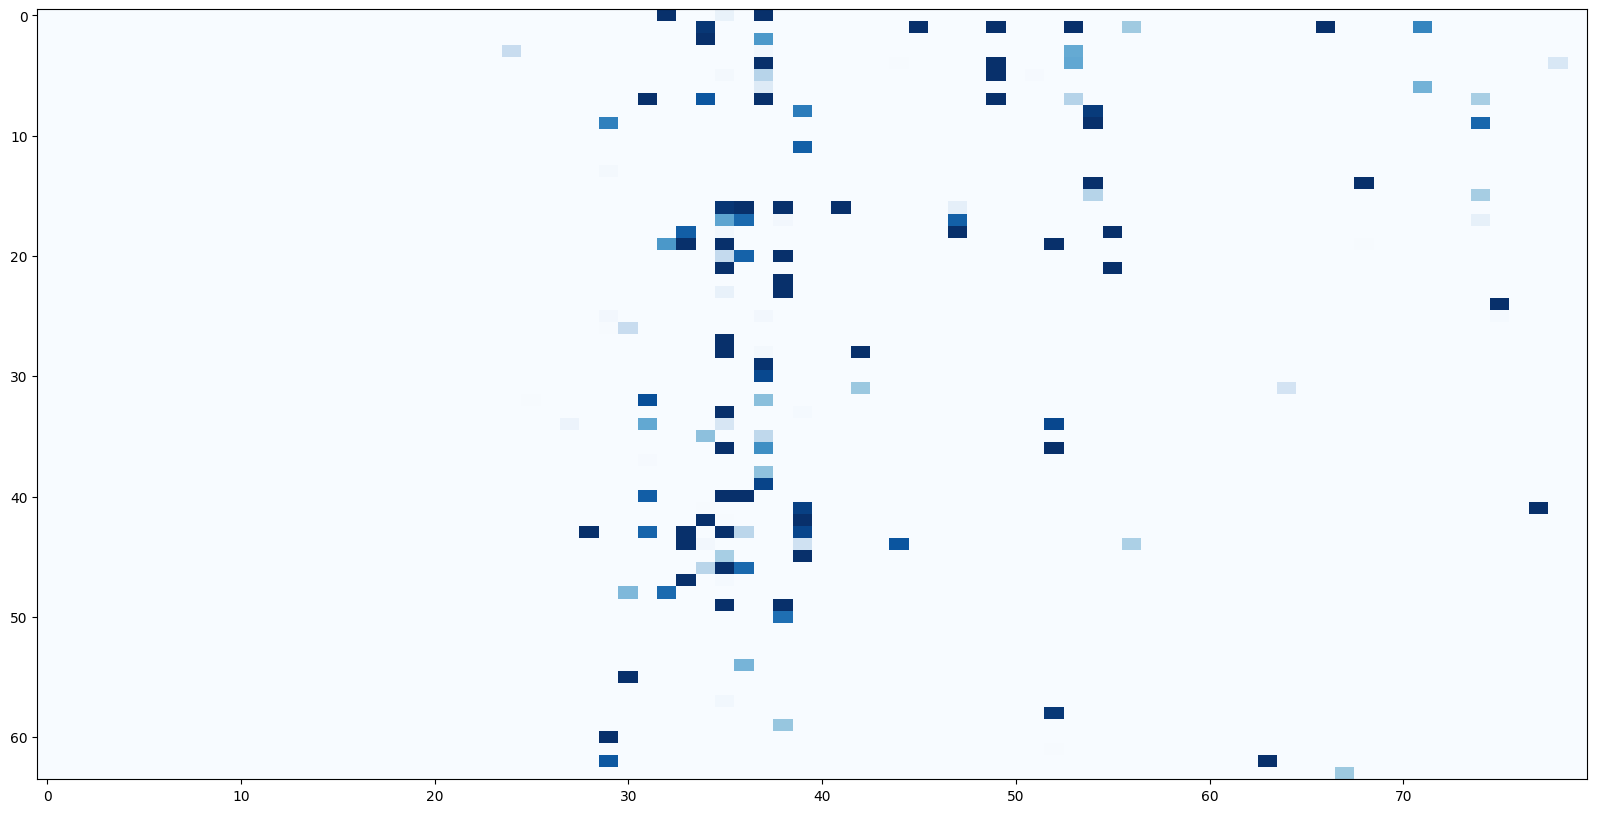

In [84]:
plt.figure(figsize=(20, 10))
plt.imshow(
    # optimal_mask.round().T.to(torch.float32).numpy(),
    torch.tensor(optimization_results["optimal_mask"]).T.to(torch.float32).numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

In [127]:
heads_selected = torch.nonzero(optimal_mask > 0.5, as_tuple=False).tolist()
heads_selected = [(layer_idx, head_idx) for layer_idx, head_idx in heads_selected if layer_idx < 51]
len(heads_selected)

69

In [139]:
(35, 19) in heads_selected

True

## Validation of the patching effect

In [93]:
from src.functional import free_gpu_cache
free_gpu_cache()
validation_set = []
validation_limit = 256

while len(validation_set) < validation_limit:
    patch, clean = get_counterfactual_samples_within_task(
        filter_by_lm_prediction=True,
        prompt_template_idx=prompt_template_idx,
        option_style=OPTION_STYLE,
        distinct_options=True,
        n_distractors=N_DISTRACTORS,
    )
    validation_set.append((clean, patch))

2025-08-13 23:52:52 __main__ INFO     Patch category: bathroom item, subject: Bathtub, object: Lotion
2025-08-13 23:52:52 __main__ INFO     Clean category: vehicle, subject: Scooter, object: Bus
2025-08-13 23:52:52 __main__ INFO     patch_must_have_options=['Lotion', 'Airplane']
2025-08-13 23:52:52 __main__ INFO     clean_must_have_options=['Bus', 'Toothpaste']
2025-08-13 23:52:52 __main__ INFO     clean_type_obj='Airplane'
2025-08-13 23:52:52 __main__ INFO     patch_type_obj='Toothpaste'
2025-08-13 23:52:52 __main__ INFO     patch_obj_idx=5 | ['Violin', 'Jasmine', 'Orange', 'Charm', 'Airplane', 'Lotion']
2025-08-13 23:52:52 __main__ INFO     clean_obj_idx=0 | ['Bus', 'Toothpaste', 'Oven', 'Trumpet', 'Giraffe', 'Chain']
type(task)=<class 'src.selection.data.SelectOrderTask'>
2025-08-13 23:52:52 __main__ INFO     Options: Violin, Jasmine, Orange, Charm, Airplane, Lotion.
What is the sixth object from the list above?
Answer:
2025-08-13 23:52:52 __main__ INFO     Bathtub | bathroom item -

In [128]:
print(patch.prompt(), ">>", patch.obj)

Options: Keyboard, Daisy, Toothbrush, Skis, Potato, Ring.
What is the second object from the list above?
Answer: >> Daisy


In [129]:
print(clean.prompt(), ">>", clean.obj)

Options: Guitar, Earring, Razor, Sweater, Dumbbell, Daffodil.
What is the fifth object from the list above?
Answer: >> Dumbbell


In [130]:
# mt.tokenizer.decode(clean_sample.obj_token_id)
mt.tokenizer.decode(clean.metadata["track_type_obj_token_id"])

' E'

In [145]:
from typing import Optional

from src.functional import (
    get_module_nnsight,
    PatchSpec,
    interpret_logits,
    patch_with_baukit,
)
from src.selection.utils import get_first_token_id


@torch.inference_mode()
def validate_q_proj_ie_on_sample_pair(
    mt: ModelandTokenizer,
    clean_sample: SelectionSample,
    patch_sample: SelectionSample,
    heads: list[tuple[int, int]],
    query_indices: int = [-1],
    verify_head_behavior_on: Optional[int] = None,
):
    clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)
    patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)

    if verify_head_behavior_on is not None:
        logger.info("Verifying head behavior...")

        logger.info(f"Clean Sample >> Ans: {clean_sample.obj}")
        clean_attn_pattern = verify_head_patterns(
            prompt=clean_tokenized,
            options=clean_sample.options,
            pivot=clean_sample.subj,
            mt=mt,
            heads=heads,
            generate_full_answer=True,
            query_index=verify_head_behavior_on,
        )

        logger.info(f"Patch Sample >> Ans: {patch_sample.obj}")
        patch_attn_pattern = verify_head_patterns(
            prompt=patch_tokenized,
            options=patch_sample.options,
            pivot=patch_sample.subj,
            mt=mt,
            heads=heads,
            generate_full_answer=True,
            query_index=verify_head_behavior_on,
        )

    logger.info(f"Caching the query states for the {len(heads)} heads")

    query_locations = [
        (layer_idx, head_idx, query_idx)
        for layer_idx, head_idx in heads
        for query_idx in query_indices
    ]

    cached_q_states, patch_output = cache_q_projections(
        mt=mt,
        input=patch_tokenized,
        query_locations=query_locations,
        return_output=True,
    )
    q_proj_patches = []
    for (layer_idx, head_idx, query_idx), q_proj in cached_q_states.items():
        q_proj_patches.append(
            PatchSpec(
                location=(
                    mt.attn_module_name_format.format(layer_idx) + ".q_proj",
                    head_idx,
                    query_idx,
                ),
                patch=q_proj,
            )
        )

    patch_logits = patch_output.logits[:, -1, :].squeeze()
    patch_predictions = interpret_logits(
        tokenizer=mt,
        logits=patch_logits,
    )
    logger.info(f"patch_prediction={[str(pred) for pred in patch_predictions]}")

    # interested_tokens = [
    #     patch_sample.ans_token_id,
    #     clean_sample.ans_token_id,
    #     clean_sample.metadata["track_type_obj_token_id"],
    # ]
    interested_tokens = clean_sample.options
    interested_tokens = [get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ") for opt in interested_tokens]
    # interested_tokens += [patch_sample.ans_token_id]
    # interested_tokens = list(set(interested_tokens))  # remove duplicates #! don't need to, made sure during sampling

    logger.info("clean run")
    clean_output = patch_with_baukit(
        mt=mt,
        inputs=clean_tokenized,
        patches=[],
    )
    clean_logits = clean_output.logits[:, -1, :].squeeze()
    clean_predictions, clean_track = interpret_logits(
        tokenizer=mt,
        logits=clean_logits,
        interested_tokens=interested_tokens,
    )
    logger.info(f"clean_prediction={[str(pred) for pred in clean_predictions]}")
    logger.info(f"clean_track={clean_track}")

    logger.info("patching the q_proj states")
    if verify_head_behavior_on is not None:
        int_attn_pattern = verify_head_patterns(
            prompt=clean_tokenized,
            options=clean_sample.options,
            pivot=clean_sample.subj,
            mt=mt,
            heads=heads,
            query_patches=q_proj_patches,
            generate_full_answer=False,
            query_index=verify_head_behavior_on,
        )
        int_logits = int_attn_pattern["logits"].squeeze()

    else:
        int_out = patch_with_baukit(
            mt=mt,
            inputs=clean_tokenized,
            patches=q_proj_patches,
        )
        int_logits = int_out.logits[:, -1, :].squeeze()

    int_predictions, int_track = interpret_logits(
        tokenizer=mt,
        logits=int_logits,
        interested_tokens=interested_tokens,
    )
    logger.info(f"int_prediction={[str(pred) for pred in int_predictions]}")
    logger.info(f"int_track={int_track}")

    return {
        "clean_sample": clean_sample,
        "patch_sample": patch_sample,
        "clean_predictions": clean_predictions,
        "patch_predictions": patch_predictions,
        "int_predictions": int_predictions,
        "clean_track": clean_track,
        "int_track": int_track,
    }


clean, patch = copy.deepcopy(validation_set[68])
# clean.default_option_style="numbered"
# patch.default_option_style="numbered"
# clean, patch = train_set[18]
# clean, patch = clean_sample, patch_sample
# clean, patch = order_sample_2, order_sample_1
# patch, clean = order_sample_1, order_sample_2
# failed_case = failed_cases[0]
# clean = failed_case["clean_sample"]
# patch = failed_case["patch_sample"]

print(clean.prompt(), ">>", clean.obj)
print(patch.prompt(), ">>", patch.obj)

validation_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    # heads=HEADS,
    heads = heads_selected,
    # heads=[(35, 19)],
    query_indices=[-3, -2, -1],
    verify_head_behavior_on=-1,
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": validation_result["clean_track"][clean_obj][0],
    "clean_logit": validation_result["clean_track"][clean_obj][1].logit,
    "target_rank": validation_result["clean_track"][target_obj][0],
    "target_logit": validation_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": validation_result["int_track"][clean_obj][0],
    "clean_logit": validation_result["int_track"][clean_obj][1].logit,
    "target_rank": validation_result["int_track"][target_obj][0],
    "target_logit": validation_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = before_intervention["clean_rank"] - after_intervention["clean_rank"]
target_rank_delta = before_intervention["target_rank"] - after_intervention["target_rank"]
logger.info(f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} ")
logger.info(f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} ")

clean_logit_delta = after_intervention["clean_logit"] - before_intervention["clean_logit"]
target_logit_delta = after_intervention["target_logit"] - before_intervention["target_logit"]
logger.info(f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} ")
logger.info(f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} ")

Options: Scarf, Shower, Spruce, Eagle, Pineapple, Refrigerator.
What is the first object from the list above?
Answer: >> Scarf
Options: Bear, Kettle, Strawberry, Notebook, Tie, Elm.
What is the second object from the list above?
Answer: >> Kettle
2025-08-14 00:25:20 __main__ INFO     Verifying head behavior...
2025-08-14 00:25:20 __main__ INFO     Clean Sample >> Ans: Scarf


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-14 00:25:24 src.experiments.utils DEBUG    Generated full answer: " Scarf.
Explanation: The first object from the list above is a scarf. A scarf is a piece of fabric worn around the neck or head for"
2025-08-14 00:25:24 src.experiments.utils DEBUG    Predictions: ['" Scar"[30760] (p=0.396, logit=18.250)', '" A"[362] (p=0.213, logit=17.625)', '" The"[578] (p=0.213, logit=17.625)', '" #"[674] (p=0.011, logit=14.688)', '" It"[1102] (p=0.011, logit=14.625)']
2025-08-14 00:25:24 src.experiments.utils INFO     Combined attention matrix for all heads


2025-08-14 00:25:24 __main__ INFO     Patch Sample >> Ans: Kettle


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-14 00:25:27 src.experiments.utils DEBUG    Generated full answer: " Kettle.
The second object from the list is a Kettle. 
The best answer is Kettle."
2025-08-14 00:25:27 src.experiments.utils DEBUG    Predictions: ['" K"[735] (p=0.645, logit=21.750)', '" The"[578] (p=0.305, logit=21.000)', '" #"[674] (p=0.022, logit=18.375)', '" A"[362] (p=0.006, logit=17.000)', '" Second"[10657] (p=0.003, logit=16.250)']
2025-08-14 00:25:27 src.experiments.utils INFO     Combined attention matrix for all heads


2025-08-14 00:25:27 __main__ INFO     Caching the query states for the 69 heads
2025-08-14 00:25:28 __main__ INFO     patch_prediction=['" K"[735] (p=0.645, logit=21.750)', '" The"[578] (p=0.305, logit=21.000)', '" #"[674] (p=0.022, logit=18.375)', '" A"[362] (p=0.006, logit=17.000)', '" Second"[10657] (p=0.003, logit=16.250)']
2025-08-14 00:25:28 __main__ INFO     clean run
2025-08-14 00:25:28 __main__ INFO     clean_prediction=['" Scar"[30760] (p=0.396, logit=18.250)', '" The"[578] (p=0.213, logit=17.625)', '" A"[362] (p=0.213, logit=17.625)', '" #"[674] (p=0.011, logit=14.688)', '" It"[1102] (p=0.011, logit=14.625)']
2025-08-14 00:25:28 __main__ INFO     clean_track=OrderedDict([(30760, (1, PredictedToken(token=' Scar', prob=0.396484375, logit=18.25, token_id=30760, metadata=None))), (36895, (7, PredictedToken(token=' Eagle', prob=0.00823974609375, logit=14.375, token_id=36895, metadata=None))), (48471, (12, PredictedToken(token=' Shower', prob=0.00469970703125, logit=13.8125, token

2025-08-14 00:25:28 __main__ INFO     int_prediction=['" Shower"[48471] (p=0.359, logit=18.500)', '" Scar"[30760] (p=0.192, logit=17.875)', '" The"[578] (p=0.192, logit=17.875)', '" A"[362] (p=0.103, logit=17.250)', '" SH"[6570] (p=0.019, logit=15.562)']
2025-08-14 00:25:28 __main__ INFO     int_track=OrderedDict([(48471, (1, PredictedToken(token=' Shower', prob=0.359375, logit=18.5, token_id=48471, metadata=None))), (30760, (3, PredictedToken(token=' Scar', prob=0.1923828125, logit=17.875, token_id=30760, metadata=None))), (15883, (11, PredictedToken(token=' Spr', prob=0.0045166015625, logit=14.125, token_id=15883, metadata=None))), (36895, (44, PredictedToken(token=' Eagle', prob=0.000652313232421875, logit=12.1875, token_id=36895, metadata=None))), (75258, (79, PredictedToken(token=' Refriger', prob=0.00016498565673828125, logit=10.8125, token_id=75258, metadata=None))), (42609, (514, PredictedToken(token=' Pine', prob=1.1205673217773438e-05, logit=8.125, token_id=42609, metadata=No

In [132]:
from tqdm.auto import tqdm

validation_results = []
for clean_sample, patch_sample in tqdm(validation_set):
    result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        # heads=HEADS,
        heads = heads_selected,
        query_indices=[-3, -2, -1],
        verify_head_behavior_on=None,
    )
    validation_results.append(result)
    print("=" * 80)

  0%|          | 0/256 [00:00<?, ?it/s]

2025-08-14 00:16:54 __main__ INFO     Caching the query states for the 69 heads


2025-08-14 00:16:54 __main__ INFO     patch_prediction=['" Tow"[41493] (p=0.762, logit=20.500)', '" The"[578] (p=0.150, logit=18.875)', '" A"[362] (p=0.049, logit=17.750)', '" \n"[720] (p=0.004, logit=15.125)', '" T"[350] (p=0.003, logit=14.938)']
2025-08-14 00:16:54 __main__ INFO     clean run
2025-08-14 00:16:54 __main__ INFO     clean_prediction=['" Motorcycle"[70762] (p=0.730, logit=21.875)', '" The"[578] (p=0.237, logit=20.750)', '" #"[674] (p=0.012, logit=17.750)', '" A"[362] (p=0.003, logit=16.375)', '" It"[1102] (p=0.002, logit=16.000)']
2025-08-14 00:16:54 __main__ INFO     clean_track=OrderedDict([(70762, (1, PredictedToken(token=' Motorcycle', prob=0.73046875, logit=21.875, token_id=70762, metadata=None))), (41493, (19, PredictedToken(token=' Tow', prob=0.00021648406982421875, logit=13.75, token_id=41493, metadata=None))), (57225, (51, PredictedToken(token=' Laptop', prob=4.267692565917969e-05, logit=12.125, token_id=57225, metadata=None))), (37128, (70, PredictedToken(token

In [133]:
before_intervention = []
after_intervention = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

In [134]:
import numpy as np

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

clean_rank_delta: 152.0078 ± 382.1804
target_rank_delta: -61.1719 ± 173.1888
clean_rank_after_intervention: 153.1875 ± 382.1847
target_rank_after_intervention: 4.3516 ± 13.0890


In [135]:
clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

clean_logit_delta: -7.4998 ± 3.2945
target_logit_delta: 6.7039 ± 3.0995
clean_logit_after_intervention: 13.2654 ± 3.2985
target_logit_after_intervention: 19.9919 ± 2.2700


In [136]:
top_1 = sum([1 for after in after_intervention if after["target_rank"] == 1])
top_1 / len(after_intervention)

0.4921875

In [137]:
counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(validation_results)})"
)

Counterfactual patching accuracy: 0.7773 (199/256)


In [138]:
for failed_case in failed_cases[:20]:
    clean_sample = failed_case["clean_sample"]
    patch_sample = failed_case["patch_sample"]
    int_track = failed_case["int_track"]
    clean_track = failed_case["clean_track"]

    print("Clean Sample:")
    print(clean_sample.prompt(), ">>", clean_sample.obj)

    print("-" * 100)
    print(
        "Track: ",
        clean_sample.metadata["track_type_obj"], " | Token"
        f"\"{mt.tokenizer.decode(clean_sample.metadata['track_type_obj_token_id'])}\"",
    )
    print("Clean:", clean_sample.obj, f"(Token: {mt.tokenizer.decode(clean_sample.ans_token_id)})")
    print("-" * 100)

    clean_track = [pred for tok_id, (rank, pred) in clean_track.items()]
    print(f"Clean Track: {json.dumps([str(pred) for pred in clean_track], indent=4)}")

    int_track = [pred for tok_id, (rank, pred) in int_track.items()]
    print(
        f"Intervened Track: {json.dumps([str(pred) for pred in int_track], indent=4)}"
    )
    print("=" * 100)

Clean Sample:
Options: Tomato, Tulip, Brooch, Harmonica, Palm, Pressure cooker.
What is the first object from the list above?
Answer: >> Tomato
----------------------------------------------------------------------------------------------------
Track:  Harmonica  | Token" Harmon"
Clean: Tomato (Token:  Tomato)
----------------------------------------------------------------------------------------------------
Clean Track: [
    "\" Tomato\"[94091] (p=0.824, logit=20.250)",
    "\" Bro\"[6031] (p=0.003, logit=14.500)",
    "\" Harmon\"[40759] (p=0.001, logit=13.688)",
    "\" Tul\"[43316] (p=0.000, logit=12.625)",
    "\" Palm\"[33578] (p=0.000, logit=12.250)",
    "\" Pressure\"[40090] (p=0.000, logit=11.125)"
]
Intervened Track: [
    "\" Palm\"[33578] (p=0.602, logit=20.500)",
    "\" Pressure\"[40090] (p=0.092, logit=18.625)",
    "\" Bro\"[6031] (p=0.039, logit=17.750)",
    "\" Harmon\"[40759] (p=0.007, logit=16.000)",
    "\" Tomato\"[94091] (p=0.002, logit=14.688)",
    "\" Tul\

In [102]:
mt.tokenizer.decode(failed_cases[0]["clean_sample"].metadata["track_type_obj_token_id"])

' Dish'

In [103]:
clean_sample.metadata.keys()

dict_keys(['track_category', 'track_type_obj', 'track_type_obj_idx', 'track_type_obj_token_id', 'tokenized'])